In [1]:
from time import time
from GeneralisedWick import *
import CC, texify
import pickle

#fockTensor = Tensor("f", ['g'], ['g'])
#h2Tensor = Tensor("v", ['g', 'g'], ['g', 'g'])

#fockTensor.getAllDiagramsGeneral()
#h2Tensor.getAllDiagramsGeneral()

#t2Tensor = Tensor("{t_{2}}", ['p', 'p'], ['h', 'h'])

In [2]:
with open("CCDEquations.pkl", 'rb') as f:
    up = pickle.Unpickler(f)
    d = up.load()
    energyEquation = d["energyEquation"]
    doublesAmplitudeEquation = d["doublesAmplitudeEquation"]
    fockTensor = d["fockTensor"]
    h2Tensor = d["h2Tensor"]
    t2Tensor = d["t2Tensor"]

In [3]:
normalOrderedHamiltonian = sum(fockTensor.diagrams) + (1. / 2.) * sum(h2Tensor.diagrams)
BCH = CC.BCHSimilarityTransform(normalOrderedHamiltonian, 0.5 * t2Tensor, 2)

In [4]:
import networkx as nx
from networkx.algorithms import isomorphism

In [5]:
CCDEnergy = evaluateWickFree(BCH, True)

In [6]:
print(CCDEnergy)

1.0 * v_{h_{0}h_{1}}^{p_{0}p_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{1}h_{0}}
 + -0.5 * v_{h_{0}h_{1}}^{p_{0}p_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{1}h_{0}}
 + -0.5 * v_{h_{0}h_{1}}^{p_{0}p_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{0}h_{1}}
 + 1.0 * v_{h_{0}h_{1}}^{p_{0}p_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{1}}


In [7]:
class node:
    def __init__(self, annihilationIndex, creationIndex, tensorName, particle=0):
        self.inIndex = annihilationIndex
        self.outIndex = creationIndex
        self.inContracted = False
        self.outContracted = False
        self.tensorName = tensorName
        self.particle = particle

In [8]:
def genNodes(term):
    for vertex in term.vertexList:
        vertex.nodes = []
        for i in range(vertex.excitationRank):
            vertex.nodes.append(node(vertex.upperIndices[i], vertex.lowerIndices[i], vertex.tensor.name, particle=i))

In [9]:
def getGraph_old(term):
    termGraph = nx.DiGraph()
    genNodes(term)
    for vertex in term.vertexList:
        for n in vertex.nodes:
            termGraph.add_node(n)
        for nodePair in itertools.combinations(vertex.nodes, 2):
            termGraph.add_edge(nodePair[0], nodePair[1])
            termGraph.add_edge(nodePair[1], nodePair[0])
    for v1, vertex1 in enumerate(term.vertexList):
        for v2, vertex2 in enumerate(term.vertexList):
            for node1 in vertex1.nodes:
                for node2 in vertex2.nodes:
                    if node1.outIndex == node2.inIndex:
                        termGraph.add_edge(node1, node2)
    return termGraph

In [10]:
def getGraph(term):
    termGraph = nx.DiGraph()
    genNodes(term)
    for v1, vertex1 in enumerate(term.vertexList):
        termGraph.add_nodes_from(vertex1.nodes, vertex=v1, freeOutType="", freeInType="")
        termGraph.add_edges_from(itertools.permutations(vertex1.nodes, 2), connection="interaction")
        for v2, vertex2 in enumerate(term.vertexList):
            for node1 in vertex1.nodes:
                for node2 in vertex2.nodes:
                    if node1.outIndex == node2.inIndex:
                        node1.outContracted = True
                        node2.inContracted = True
                        termGraph.add_edge(node1, node2, connection="propagation")
        for node1 in vertex1.nodes:
            termGraph.nodes[node1]["particle"]=node1.particle
            if not node1.outContracted:
                if node1.outIndex.occupiedInVacuum:
                    termGraph.nodes[node1]["freeOutType"]="h"
                else:
                    termGraph.nodes[node1]["freeOutType"]="p"
            if not node1.inContracted:
                if node1.inIndex.occupiedInVacuum:
                    termGraph.nodes[node1]["freeInType"]="h"
                else:
                    termGraph.nodes[node1]["freeInType"]="p"
    return termGraph

In [11]:
direct = getGraph(CCDEnergy.summandList[0])
exchange = getGraph(CCDEnergy.summandList[1])

In [12]:
layout = nx.multipartite_layout(direct, "vertex", "horizontal")

In [13]:
direct.edges

OutEdgeView([(<__main__.node object at 0x7f4baa9f5b70>, <__main__.node object at 0x7f4baa9f55f8>), (<__main__.node object at 0x7f4baa9f5b70>, <__main__.node object at 0x7f4baa9a5c50>), (<__main__.node object at 0x7f4baa9f55f8>, <__main__.node object at 0x7f4baa9f5b70>), (<__main__.node object at 0x7f4baa9f55f8>, <__main__.node object at 0x7f4baa9a5630>), (<__main__.node object at 0x7f4baa9a5c50>, <__main__.node object at 0x7f4baa9a5630>), (<__main__.node object at 0x7f4baa9a5c50>, <__main__.node object at 0x7f4baa9f5b70>), (<__main__.node object at 0x7f4baa9a5630>, <__main__.node object at 0x7f4baa9a5c50>), (<__main__.node object at 0x7f4baa9a5630>, <__main__.node object at 0x7f4baa9f55f8>)])

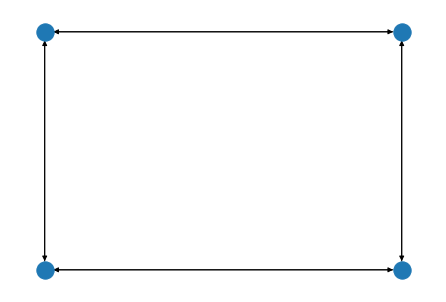

In [14]:
nx.draw(direct, nx.multipartite_layout(direct, "vertex", "horizontal"))

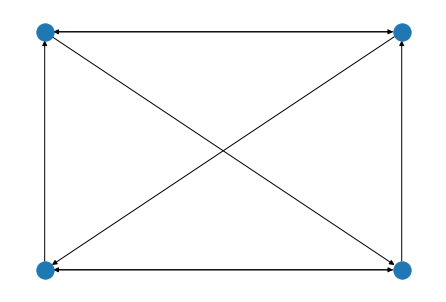

In [15]:
nx.draw(exchange, nx.multipartite_layout(exchange, "vertex", "horizontal"))

In [16]:
direct1 = getGraph(CCDEnergy.summandList[3])
exchange1 = getGraph(CCDEnergy.summandList[2])

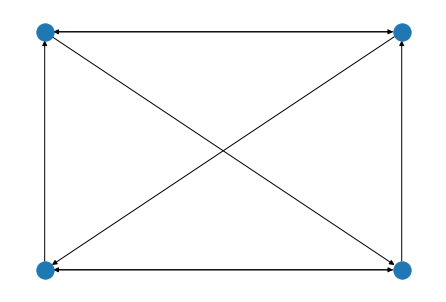

In [17]:
nx.draw(exchange1, nx.multipartite_layout(exchange1, "vertex", "horizontal"))

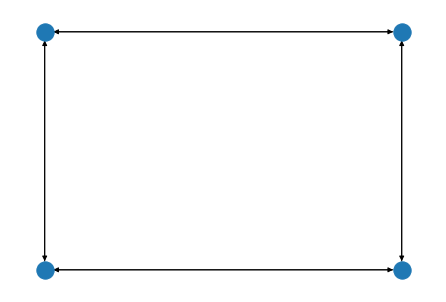

In [18]:
nx.draw(direct1, nx.multipartite_layout(direct1, "vertex", "horizontal"))

In [19]:
print(nx.is_isomorphic(direct, direct))
print(nx.is_isomorphic(direct, exchange))
print(nx.is_isomorphic(direct, exchange1))
print(nx.is_isomorphic(direct, direct1))
print(nx.is_isomorphic(exchange, direct))
print(nx.is_isomorphic(exchange, exchange))
print(nx.is_isomorphic(exchange, exchange1))
print(nx.is_isomorphic(exchange, direct1))
print(nx.is_isomorphic(exchange1, direct))
print(nx.is_isomorphic(exchange1, exchange))
print(nx.is_isomorphic(exchange1, exchange1))
print(nx.is_isomorphic(exchange, direct1))
print(nx.is_isomorphic(direct1, direct))
print(nx.is_isomorphic(direct1, exchange))
print(nx.is_isomorphic(direct1, exchange1))
print(nx.is_isomorphic(direct1, direct1))

True
False
False
True
False
True
True
False
False
True
True
False
True
False
False
True


In [20]:
def isProportional(term1, term2):
    term1Graph = getGraph(term1)
    term2Graph = getGraph(term2)
    DiGM = isomorphism.DiGraphMatcher(term1Graph, term2Graph)
    return (term1.tensorList == term2.tensorList) and DiGM.is_isomorphic() and all([DiGM.semantic_feasibility(DiGM.mapping[n], n) for n in DiGM.mapping.keys()])

In [21]:
def collectEquation(equation):
    collectedEquation = TensorSum([])
    for summand in equation.summandList:
        included = False
        for uniqueSummand in collectedEquation.summandList:
            if isProportional(summand, uniqueSummand):
                included = True
                uniqueSummand.prefactor += summand.prefactor
        if not included:
            collectedEquation.summandList.append(copy(summand))
    return collectedEquation

In [22]:
print(CCDEnergy)

1.0 * v_{h_{0}h_{1}}^{p_{0}p_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{1}h_{0}}
 + -0.5 * v_{h_{0}h_{1}}^{p_{0}p_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{1}h_{0}}
 + -0.5 * v_{h_{0}h_{1}}^{p_{0}p_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{0}h_{1}}
 + 1.0 * v_{h_{0}h_{1}}^{p_{0}p_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{1}}


In [23]:
print(collectEquation(CCDEnergy))

2.0 * v_{h_{0}h_{1}}^{p_{0}p_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{1}h_{0}}
 + -1.0 * v_{h_{0}h_{1}}^{p_{0}p_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{1}h_{0}}


In [24]:
CCDAmplitudes = evaluateWickFree(BCH, True, (['p', 'p'], ['h', 'h']))

In [25]:
len(CCDAmplitudes.summandList)

708

In [26]:
print(CCDAmplitudes)

0.25 * v_{p_{0}p_{1}}^{h_{0}h_{1}}
 + 0.25 * v_{p_{0}p_{1}}^{h_{0}h_{1}}
 + 0.25 * v_{p_{0}p_{1}}^{h_{0}h_{1}}
 + 0.25 * v_{p_{0}p_{1}}^{h_{0}h_{1}}
 + -0.25 * f_{h_{0}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{3}}
 + 0.25 * f_{h_{0}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{0}}
 + 0.25 * f_{h_{0}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{0}}
 + -0.25 * f_{h_{0}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{3}}
 + -0.25 * f_{h_{0}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{3}}
 + 0.25 * f_{h_{0}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{0}}
 + -0.25 * f_{h_{0}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{3}}
 + 0.25 * f_{h_{0}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{0}}
 + -0.25 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{2}p_{1}}^{h_{0}h_{1}}
 + 0.25 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{1}p_{3}}^{h_{0}h_{1}}
 + -0.25 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{2}p_{1}}^{h_{0}h_{1}}
 + 0.25 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{1}p_{3}}^{h_{0}h_{1}}
 + 0.25 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{1}p_{3}}^{h_{0}h_{1}}
 + -0.25 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{2}p_{1}}^{h_

In [27]:
print(collectEquation(CCDAmplitudes))

1.0 * v_{p_{0}p_{1}}^{h_{0}h_{1}}
 + 0.0 * f_{h_{0}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{3}}
 + 0.0 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{2}p_{1}}^{h_{0}h_{1}}
 + 0.0 * v_{h_{0}h_{1}}^{h_{2}h_{3}}{t_{2}}_{p_{0}p_{1}}^{h_{1}h_{0}}
 + -2.0 * v_{h_{0}p_{0}}^{h_{1}p_{1}}{t_{2}}_{p_{2}p_{1}}^{h_{0}h_{3}}
 + 2.0 * v_{h_{0}p_{0}}^{h_{1}p_{1}}{t_{2}}_{p_{2}p_{1}}^{h_{2}h_{0}}
 + -2.0 * v_{h_{0}p_{0}}^{p_{1}h_{1}}{t_{2}}_{p_{2}p_{1}}^{h_{0}h_{3}}
 + 4.0 * v_{h_{0}p_{0}}^{p_{1}h_{1}}{t_{2}}_{p_{2}p_{1}}^{h_{2}h_{0}}
 + -2.0 * v_{p_{0}h_{0}}^{h_{1}p_{1}}{t_{2}}_{p_{2}p_{1}}^{h_{0}h_{3}}
 + 4.0 * v_{p_{0}h_{0}}^{h_{1}p_{1}}{t_{2}}_{p_{2}p_{1}}^{h_{2}h_{0}}
 + -2.0 * v_{p_{0}h_{0}}^{p_{1}h_{1}}{t_{2}}_{p_{2}p_{1}}^{h_{0}h_{3}}
 + 2.0 * v_{p_{0}h_{0}}^{p_{1}h_{1}}{t_{2}}_{p_{2}p_{1}}^{h_{2}h_{0}}
 + 0.0 * v_{p_{0}p_{1}}^{p_{2}p_{3}}{t_{2}}_{p_{3}p_{2}}^{h_{0}h_{1}}
 + 16.0 * v_{h_{0}h_{1}}^{p_{0}p_{1}}{t_{2}}_{p_{2}p_{3}}^{h_{2}h_{3}}{t_{2}}_{p_{1}p_{0}}^{h_{1}h_{0}}
 + -8.0 * v_{h_{0}h_{1}}^{p_{0}p_{1}}{

In [28]:
print(sum(CCDAmplitudes.summandList[4:20]))

-0.25 * f_{h_{0}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{3}}
 + 0.25 * f_{h_{0}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{0}}
 + 0.25 * f_{h_{0}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{0}}
 + -0.25 * f_{h_{0}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{3}}
 + -0.25 * f_{h_{0}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{3}}
 + 0.25 * f_{h_{0}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{0}}
 + -0.25 * f_{h_{0}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{3}}
 + 0.25 * f_{h_{0}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{0}}
 + -0.25 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{2}p_{1}}^{h_{0}h_{1}}
 + 0.25 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{1}p_{3}}^{h_{0}h_{1}}
 + -0.25 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{2}p_{1}}^{h_{0}h_{1}}
 + 0.25 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{1}p_{3}}^{h_{0}h_{1}}
 + 0.25 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{1}p_{3}}^{h_{0}h_{1}}
 + -0.25 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{2}p_{1}}^{h_{0}h_{1}}
 + -0.25 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{2}p_{1}}^{h_{0}h_{1}}
 + 0.25 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{1}p_{3}}^{h_{0}h_{1}}


In [29]:
D2a = sum(CCDAmplitudes.summandList[12:20])
D2b = sum(CCDAmplitudes.summandList[4:12])

In [30]:
print(D2a)
print(D2b)

-0.25 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{2}p_{1}}^{h_{0}h_{1}}
 + 0.25 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{1}p_{3}}^{h_{0}h_{1}}
 + -0.25 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{2}p_{1}}^{h_{0}h_{1}}
 + 0.25 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{1}p_{3}}^{h_{0}h_{1}}
 + 0.25 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{1}p_{3}}^{h_{0}h_{1}}
 + -0.25 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{2}p_{1}}^{h_{0}h_{1}}
 + -0.25 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{2}p_{1}}^{h_{0}h_{1}}
 + 0.25 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{1}p_{3}}^{h_{0}h_{1}}
-0.25 * f_{h_{0}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{3}}
 + 0.25 * f_{h_{0}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{0}}
 + 0.25 * f_{h_{0}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{0}}
 + -0.25 * f_{h_{0}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{3}}
 + -0.25 * f_{h_{0}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{3}}
 + 0.25 * f_{h_{0}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{0}}
 + -0.25 * f_{h_{0}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{3}}
 + 0.25 * f_{h_{0}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{0}}


In [31]:
print(collectEquation(D2a))

0.0 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{2}p_{1}}^{h_{0}h_{1}}


In [32]:
isProportional(D2a.summandList[0], D2a.summandList[1])

True

In [33]:
D2a.summandList[0]

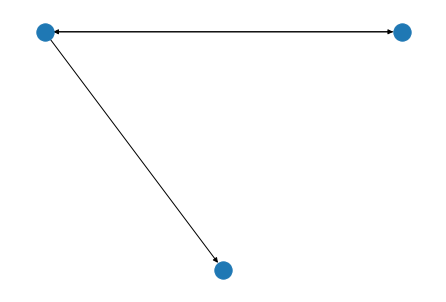

In [34]:
firstTest = getGraph(D2a.summandList[0])
nx.draw(firstTest, nx.multipartite_layout(firstTest, "vertex", "horizontal"))

In [35]:
firstTest.adj

AdjacencyView({<__main__.node object at 0x7f4ba6b909b0>: {}, <__main__.node object at 0x7f4ba6b904a8>: {<__main__.node object at 0x7f4ba6b90b38>: {'connection': 'interaction'}}, <__main__.node object at 0x7f4ba6b90b38>: {<__main__.node object at 0x7f4ba6b904a8>: {'connection': 'interaction'}, <__main__.node object at 0x7f4ba6b909b0>: {'connection': 'propagation'}}})

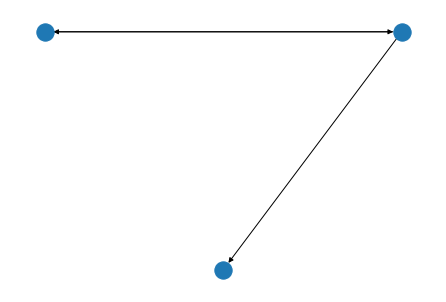

In [36]:
secondTest = getGraph(D2a.summandList[1])
nx.draw(secondTest, nx.multipartite_layout(secondTest, "vertex", "horizontal"))

In [37]:
def followPropagation(graph, node):
    currentNode = node
#    connections = graph.edges(data="connection")
    while currentNode.outContracted:
        for nbr, datadict in graph.adj[node].items():
            if datadict["connection"] == "propagation":
                currentNode = nbr
    return currentNode

In [38]:
def getFreeIndexPairs(graph):
    freeIndexPairsDict = {}
    for startNode in graph.nodes:
        if not startNode.inContracted:
            inIndex = startNode.inIndex
            endNode = followPropagation(graph, startNode)
            outIndex = endNode.outIndex
#            print(inIndex, outIndex)
            freeIndexPairsDict[startNode] = endNode
    return freeIndexPairsDict

In [39]:
def isProportional1(term1, term2):
    term1Graph = getGraph(term1)
    term2Graph = getGraph(term2)
    DiGM = isomorphism.DiGraphMatcher(term1Graph, term2Graph)
    term1FreeIndexPairs = getFreeIndexPairs(term1Graph)
    term2FreeIndexPairs = getFreeIndexPairs(term2Graph)
    return (term1.tensorList == term2.tensorList) and DiGM.is_isomorphic() and all([DiGM.semantic_feasibility(DiGM.mapping[n], n) for n in DiGM.mapping.keys()]) and all([DiGM.mapping[term1FreeIndexPairs[startNode]] == term2FreeIndexPairs[DiGM.mapping[startNode]] for startNode in term1FreeIndexPairs.keys()]) and len(term1FreeIndexPairs) == len(term2FreeIndexPairs)

-0.25 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{2}p_{1}}^{h_{0}h_{1}}


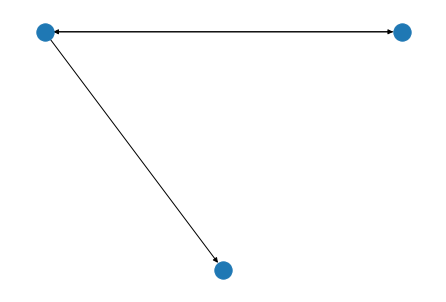

In [40]:
i=0
print(D2a.summandList[i])
getFreeIndexPairs(getGraph(D2a.summandList[i]))
test = getGraph(D2a.summandList[i])
nx.draw(test, nx.multipartite_layout(test, "vertex", "horizontal"))

0.25 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{1}p_{3}}^{h_{0}h_{1}}


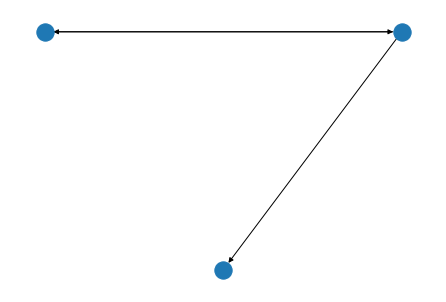

In [41]:
i=1
print(D2a.summandList[i])
getFreeIndexPairs(getGraph(D2a.summandList[i]))
test = getGraph(D2a.summandList[i])
nx.draw(test, nx.multipartite_layout(test, "vertex", "horizontal"))

-0.25 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{2}p_{1}}^{h_{0}h_{1}}


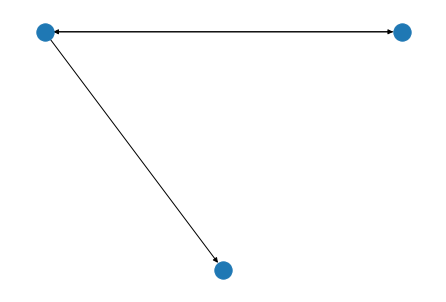

In [42]:
i=2
print(D2a.summandList[i])
getFreeIndexPairs(getGraph(D2a.summandList[i]))
test = getGraph(D2a.summandList[i])
nx.draw(test, nx.multipartite_layout(test, "vertex", "horizontal"))

0.25 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{1}p_{3}}^{h_{0}h_{1}}


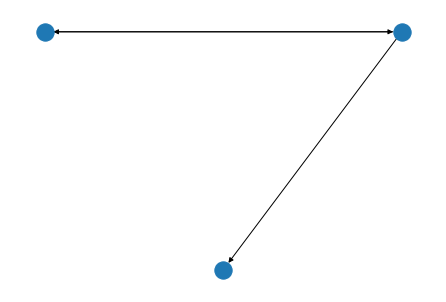

In [43]:
i=3
print(D2a.summandList[i])
getFreeIndexPairs(getGraph(D2a.summandList[i]))
test = getGraph(D2a.summandList[i])
nx.draw(test, nx.multipartite_layout(test, "vertex", "horizontal"))

0.25 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{1}p_{3}}^{h_{0}h_{1}}


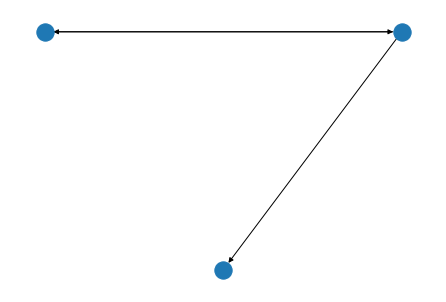

In [44]:
i=4
print(D2a.summandList[i])
getFreeIndexPairs(getGraph(D2a.summandList[i]))
test = getGraph(D2a.summandList[i])
nx.draw(test, nx.multipartite_layout(test, "vertex", "horizontal"))

-0.25 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{2}p_{1}}^{h_{0}h_{1}}


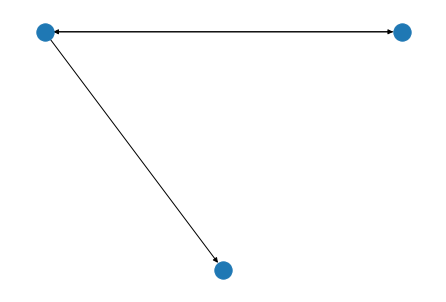

In [45]:
i=5
print(D2a.summandList[i])
getFreeIndexPairs(getGraph(D2a.summandList[i]))
test = getGraph(D2a.summandList[i])
nx.draw(test, nx.multipartite_layout(test, "vertex", "horizontal"))

-0.25 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{2}p_{1}}^{h_{0}h_{1}}


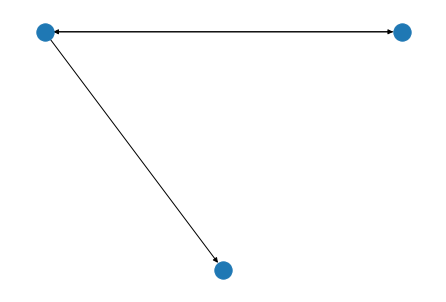

In [46]:
i=6
print(D2a.summandList[i])
getFreeIndexPairs(getGraph(D2a.summandList[i]))
test = getGraph(D2a.summandList[i])
nx.draw(test, nx.multipartite_layout(test, "vertex", "horizontal"))

0.25 * f_{p_{0}}^{p_{1}}{t_{2}}_{p_{1}p_{3}}^{h_{0}h_{1}}


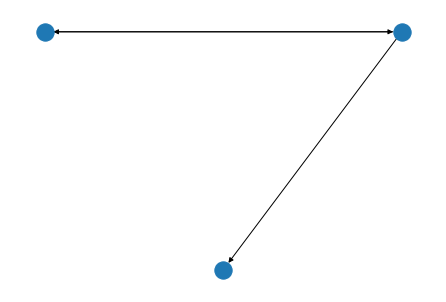

In [47]:
i=7
print(D2a.summandList[i])
getFreeIndexPairs(getGraph(D2a.summandList[i]))
test = getGraph(D2a.summandList[i])
nx.draw(test, nx.multipartite_layout(test, "vertex", "horizontal"))

In [48]:
isProportional1(D2a.summandList[0], D2a.summandList[1])

True

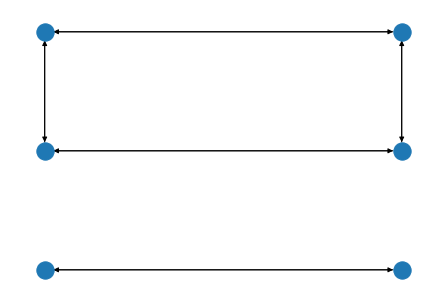

In [49]:
last = getGraph(CCDAmplitudes.summandList[-1])
nx.draw(last, nx.multipartite_layout(last, "vertex", "horizontal"))

In [50]:
print(CCDAmplitudes.summandList[-1])

1.0 * {t_{2}}_{p_{0}p_{1}}^{h_{0}h_{1}}v_{h_{2}h_{3}}^{p_{2}p_{3}}{t_{2}}_{p_{2}p_{3}}^{h_{2}h_{3}}


In [51]:
print(len(doublesAmplitudeEquation.summandList))
print(doublesAmplitudeEquation)

708
2.0 * v_{p_{1}p_{0}}^{h_{1}h_{0}}
 + -1.0 * v_{p_{0}p_{1}}^{h_{1}h_{0}}
 + -1.0 * v_{p_{1}p_{0}}^{h_{0}h_{1}}
 + 2.0 * v_{p_{0}p_{1}}^{h_{0}h_{1}}
 + 1.0 * f_{h_{2}}^{h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{1}}
 + -2.0 * f_{h_{2}}^{h_{0}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{1}}
 + -2.0 * f_{h_{2}}^{h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{1}h_{2}}
 + 1.0 * f_{h_{2}}^{h_{0}}{t_{2}}_{p_{0}p_{1}}^{h_{1}h_{2}}
 + -2.0 * f_{h_{2}}^{h_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{0}}
 + 1.0 * f_{h_{2}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{0}}
 + 1.0 * f_{h_{2}}^{h_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{0}h_{2}}
 + -2.0 * f_{h_{2}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{2}}
 + -1.0 * f_{p_{1}}^{p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{1}h_{0}}
 + 2.0 * f_{p_{1}}^{p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{1}h_{0}}
 + 2.0 * f_{p_{0}}^{p_{3}}{t_{2}}_{p_{1}p_{3}}^{h_{1}h_{0}}
 + -1.0 * f_{p_{0}}^{p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{1}h_{0}}
 + 2.0 * f_{p_{1}}^{p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{0}h_{1}}
 + -1.0 * f_{p_{1}}^{p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{0}h_{1}}
 +

In [52]:
collectedDoublesAmplitudeEquation = doublesAmplitudeEquation.collectIsomorphicTerms()
print(collectedDoublesAmplitudeEquation)

2.0 * v_{p_{1}p_{0}}^{h_{1}h_{0}}
 + -4.0 * f_{h_{2}}^{h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{1}}
 + 4.0 * f_{p_{1}}^{p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{1}h_{0}}
 + 2.0 * v_{h_{2}h_{3}}^{h_{1}h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{3}h_{2}}
 + -4.0 * v_{h_{2}p_{1}}^{h_{0}p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + -4.0 * v_{h_{2}p_{1}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{2}h_{1}}
 + -4.0 * v_{h_{2}p_{1}}^{p_{3}h_{0}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + 8.0 * v_{h_{2}p_{1}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{0}}^{h_{2}h_{1}}
 + 2.0 * v_{p_{1}p_{0}}^{p_{4}p_{5}}{t_{2}}_{p_{5}p_{4}}^{h_{1}h_{0}}
 + 4.0 * v_{h_{2}h_{3}}^{p_{2}p_{3}}{t_{2}}_{p_{1}p_{0}}^{h_{1}h_{0}}{t_{2}}_{p_{3}p_{2}}^{h_{3}h_{2}}
 + -2.0 * v_{h_{2}h_{3}}^{p_{2}p_{3}}{t_{2}}_{p_{1}p_{0}}^{h_{1}h_{0}}{t_{2}}_{p_{2}p_{3}}^{h_{3}h_{2}}
 + -8.0 * v_{h_{2}h_{3}}^{p_{2}p_{3}}{t_{2}}_{p_{1}p_{3}}^{h_{1}h_{0}}{t_{2}}_{p_{0}p_{2}}^{h_{3}h_{2}}
 + 4.0 * v_{h_{2}h_{3}}^{p_{2}p_{3}}{t_{2}}_{p_{1}p_{2}}^{h_{1}h_{0}}{t_{2}}_{p_{0}p_{3}}^{h_{3}h_{2}}
 + 2.0 *

In [53]:
len(collectedDoublesAmplitudeEquation.summandList)

24

In [54]:
projection = CC.projectionManifold(2)
projectedDoublesAmplitudeEquation = evaluateWickFree(projection * BCH, True)

In [55]:
collectedProjectedDoublesAmplitudeEquation = collectEquation(projectedDoublesAmplitudeEquation)

In [56]:
print(collectedDoublesAmplitudeEquation)

2.0 * v_{p_{1}p_{0}}^{h_{1}h_{0}}
 + -4.0 * f_{h_{2}}^{h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{1}}
 + 4.0 * f_{p_{1}}^{p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{1}h_{0}}
 + 2.0 * v_{h_{2}h_{3}}^{h_{1}h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{3}h_{2}}
 + -4.0 * v_{h_{2}p_{1}}^{h_{0}p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + -4.0 * v_{h_{2}p_{1}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{2}h_{1}}
 + -4.0 * v_{h_{2}p_{1}}^{p_{3}h_{0}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + 8.0 * v_{h_{2}p_{1}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{0}}^{h_{2}h_{1}}
 + 2.0 * v_{p_{1}p_{0}}^{p_{4}p_{5}}{t_{2}}_{p_{5}p_{4}}^{h_{1}h_{0}}
 + 4.0 * v_{h_{2}h_{3}}^{p_{2}p_{3}}{t_{2}}_{p_{1}p_{0}}^{h_{1}h_{0}}{t_{2}}_{p_{3}p_{2}}^{h_{3}h_{2}}
 + -2.0 * v_{h_{2}h_{3}}^{p_{2}p_{3}}{t_{2}}_{p_{1}p_{0}}^{h_{1}h_{0}}{t_{2}}_{p_{2}p_{3}}^{h_{3}h_{2}}
 + -8.0 * v_{h_{2}h_{3}}^{p_{2}p_{3}}{t_{2}}_{p_{1}p_{3}}^{h_{1}h_{0}}{t_{2}}_{p_{0}p_{2}}^{h_{3}h_{2}}
 + 4.0 * v_{h_{2}h_{3}}^{p_{2}p_{3}}{t_{2}}_{p_{1}p_{2}}^{h_{1}h_{0}}{t_{2}}_{p_{0}p_{3}}^{h_{3}h_{2}}
 + 2.0 *

In [57]:
print(collectedProjectedDoublesAmplitudeEquation)

4.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{p_{1}p_{0}}^{h_{1}h_{0}}
 + -2.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{p_{0}p_{1}}^{h_{1}h_{0}}
 + 4.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{1}}
 + -8.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{0}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{1}}
 + -4.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{p_{1}}^{p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{1}h_{0}}
 + 8.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{p_{1}}^{p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{1}h_{0}}
 + -2.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{h_{2}h_{3}}^{h_{1}h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{3}h_{2}}
 + 4.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{h_{2}h_{3}}^{h_{1}h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{3}}
 + -4.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{h_{2}p_{1}}^{h_{0}p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + 4.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{h_{2}p_{1}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{2}h_{1}}
 + -4.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{h_{2}p_{0}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + 

In [58]:
collectedUnprojectedDoublesAmplitudeEquation = copy(collectedProjectedDoublesAmplitudeEquation)
for summand in collectedUnprojectedDoublesAmplitudeEquation.summandList:
    summand.tensorList.pop(0)
    summand.vertexList.pop(0)

In [59]:
print(collectedUnprojectedDoublesAmplitudeEquation)

4.0 * v_{p_{1}p_{0}}^{h_{1}h_{0}}
 + -2.0 * v_{p_{0}p_{1}}^{h_{1}h_{0}}
 + 4.0 * f_{h_{2}}^{h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{1}}
 + -8.0 * f_{h_{2}}^{h_{0}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{1}}
 + -4.0 * f_{p_{1}}^{p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{1}h_{0}}
 + 8.0 * f_{p_{1}}^{p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{1}h_{0}}
 + -2.0 * v_{h_{2}h_{3}}^{h_{1}h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{3}h_{2}}
 + 4.0 * v_{h_{2}h_{3}}^{h_{1}h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{3}}
 + -4.0 * v_{h_{2}p_{1}}^{h_{0}p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + 4.0 * v_{h_{2}p_{1}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{2}h_{1}}
 + -4.0 * v_{h_{2}p_{0}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + 2.0 * v_{h_{2}p_{1}}^{p_{3}h_{0}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + -8.0 * v_{h_{2}p_{1}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{0}}^{h_{2}h_{1}}
 + 8.0 * v_{h_{2}p_{0}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + 2.0 * v_{p_{1}h_{2}}^{h_{0}p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + -8.0 * v_{p_{1}h_{2}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p

In [60]:
print(doublesAmplitudeEquation)

2.0 * v_{p_{1}p_{0}}^{h_{1}h_{0}}
 + -1.0 * v_{p_{0}p_{1}}^{h_{1}h_{0}}
 + -1.0 * v_{p_{1}p_{0}}^{h_{0}h_{1}}
 + 2.0 * v_{p_{0}p_{1}}^{h_{0}h_{1}}
 + 1.0 * f_{h_{2}}^{h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{1}}
 + -2.0 * f_{h_{2}}^{h_{0}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{1}}
 + -2.0 * f_{h_{2}}^{h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{1}h_{2}}
 + 1.0 * f_{h_{2}}^{h_{0}}{t_{2}}_{p_{0}p_{1}}^{h_{1}h_{2}}
 + -2.0 * f_{h_{2}}^{h_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{0}}
 + 1.0 * f_{h_{2}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{0}}
 + 1.0 * f_{h_{2}}^{h_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{0}h_{2}}
 + -2.0 * f_{h_{2}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{2}}
 + -1.0 * f_{p_{1}}^{p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{1}h_{0}}
 + 2.0 * f_{p_{1}}^{p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{1}h_{0}}
 + 2.0 * f_{p_{0}}^{p_{3}}{t_{2}}_{p_{1}p_{3}}^{h_{1}h_{0}}
 + -1.0 * f_{p_{0}}^{p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{1}h_{0}}
 + 2.0 * f_{p_{1}}^{p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{0}h_{1}}
 + -1.0 * f_{p_{1}}^{p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{0}h_{1}}
 + -1.

In [61]:
bohr = 0.529177249

H2sep = 1.605 * bohr

mol = gto.Mole()
mol.verbose = 1
mol.atom = 'Be 0 0 0'
mol.basis = 'sto-3g'
#mol.atom = 'H 0 0 0; H 0 0 ' + str(H2sep)
#mol.basis = '6-31g'
mol.spin = 0
mol.build()

Enuc = mol.energy_nuc()

mf = scf.ROHF(mol)
mf.kernel()

cisolver = fci.FCI(mol, mf.mo_coeff)

Norbs = mol.nao
Nocc = mf.nelectron_alpha
vacuum = [1] * Nocc + [0] * (Norbs - Nocc)

h1 = mf.mo_coeff.T.dot(mf.get_hcore()).dot(mf.mo_coeff)
eri = ao2mo.kernel(mol, mf.mo_coeff, compact=False)

h2Tensor.array = eri.reshape((Norbs, Norbs, Norbs, Norbs)).swapaxes(2,3).swapaxes(1,2)

fock = h1
for p in range(Norbs):
    for q in range(Norbs):
        fock[p,q] += sum([2 * h2Tensor.array[p,i,q,i] - h2Tensor.array[p,i,i,q] for i in range(Nocc)])
fockTensor.array = fock

fockTensor.assignDiagramArrays(vacuum)
h2Tensor.assignDiagramArrays(vacuum)
t2Tensor.getShape(vacuum)

In [62]:
print(contractTensorSum(doublesAmplitudeEquation))

[[[[0.03119816 0.04112514]
   [0.04112514 0.17361796]]

  [[0.         0.        ]
   [0.         0.        ]]

  [[0.         0.        ]
   [0.         0.        ]]]


 [[[0.         0.        ]
   [0.         0.        ]]

  [[0.03119816 0.04112514]
   [0.04112514 0.17361796]]

  [[0.         0.        ]
   [0.         0.        ]]]


 [[[0.         0.        ]
   [0.         0.        ]]

  [[0.         0.        ]
   [0.         0.        ]]

  [[0.03119816 0.04112514]
   [0.04112514 0.17361796]]]]


In [63]:
print(contractTensorSum(collectedDoublesAmplitudeEquation))

[[[[0.03119816 0.04112514]
   [0.04112514 0.17361796]]

  [[0.         0.        ]
   [0.         0.        ]]

  [[0.         0.        ]
   [0.         0.        ]]]


 [[[0.         0.        ]
   [0.         0.        ]]

  [[0.03119816 0.04112514]
   [0.04112514 0.17361796]]

  [[0.         0.        ]
   [0.         0.        ]]]


 [[[0.         0.        ]
   [0.         0.        ]]

  [[0.         0.        ]
   [0.         0.        ]]

  [[0.03119816 0.04112514]
   [0.04112514 0.17361796]]]]


In [64]:
print(sum([contractTensorSum(TensorSum([s])) for s in doublesAmplitudeEquation.summandList]))

[[[[0.03119816 0.04112514]
   [0.04112514 0.17361796]]

  [[0.         0.        ]
   [0.         0.        ]]

  [[0.         0.        ]
   [0.         0.        ]]]


 [[[0.         0.        ]
   [0.         0.        ]]

  [[0.03119816 0.04112514]
   [0.04112514 0.17361796]]

  [[0.         0.        ]
   [0.         0.        ]]]


 [[[0.         0.        ]
   [0.         0.        ]]

  [[0.         0.        ]
   [0.         0.        ]]

  [[0.03119816 0.04112514]
   [0.04112514 0.17361796]]]]


In [65]:
print(sum([contractTensorSum(TensorSum([s])) for s in collectedDoublesAmplitudeEquation.summandList]))

[[[[0.03119816 0.04112514]
   [0.04112514 0.17361796]]

  [[0.         0.        ]
   [0.         0.        ]]

  [[0.         0.        ]
   [0.         0.        ]]]


 [[[0.         0.        ]
   [0.         0.        ]]

  [[0.03119816 0.04112514]
   [0.04112514 0.17361796]]

  [[0.         0.        ]
   [0.         0.        ]]]


 [[[0.         0.        ]
   [0.         0.        ]]

  [[0.         0.        ]
   [0.         0.        ]]

  [[0.03119816 0.04112514]
   [0.04112514 0.17361796]]]]


In [66]:
(contractTensorSum(doublesAmplitudeEquation) == contractTensorSum(collectedDoublesAmplitudeEquation)).all()

False

In [67]:
(contractTensorSum(collectedDoublesAmplitudeEquation) == sum([contractTensorSum(TensorSum([s])) for s in doublesAmplitudeEquation.summandList])).all()

True

In [68]:
(contractTensorSum(collectedDoublesAmplitudeEquation) == sum([contractTensorSum(TensorSum([s])) for s in collectedDoublesAmplitudeEquation.summandList])).all()

True

In [69]:
contractTensorSum(CCDAmplitudes)

array([[[[0.01559908, 0.02056257],
         [0.02056257, 0.08680898]],

        [[0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.        , 0.        ],
         [0.        , 0.        ]]],


       [[[0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.01559908, 0.02056257],
         [0.02056257, 0.08680898]],

        [[0.        , 0.        ],
         [0.        , 0.        ]]],


       [[[0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.01559908, 0.02056257],
         [0.02056257, 0.08680898]]]])

In [70]:
(contractTensorSum(CCDAmplitudes.collectIsomorphicTerms()) == contractTensorSum(CCDAmplitudes)).all()

True

In [71]:
(contractTensorSum(collectedDoublesAmplitudeEquation) == 2 * contractTensorSum(CCDAmplitudes)).all()

True

In [72]:
4 * contractTensorSum(CCDAmplitudes) - 2 * contractTensorSum(CCDAmplitudes).swapaxes(0,1)

array([[[[0.03119816, 0.04112514],
         [0.04112514, 0.17361796]],

        [[0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.        , 0.        ],
         [0.        , 0.        ]]],


       [[[0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.03119816, 0.04112514],
         [0.04112514, 0.17361796]],

        [[0.        , 0.        ],
         [0.        , 0.        ]]],


       [[[0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.03119816, 0.04112514],
         [0.04112514, 0.17361796]]]])

In [73]:
(contractTensorSum(doublesAmplitudeEquation) == 4 * contractTensorSum(CCDAmplitudes) - 2 * contractTensorSum(CCDAmplitudes).swapaxes(0,1)).all()

False

In [74]:
np.amax(abs(4 * contractTensorSum(CCDAmplitudes) - 2 * contractTensorSum(CCDAmplitudes).swapaxes(0,1) - contractTensorSum(doublesAmplitudeEquation)))

6.938893903907228e-18

In [75]:
np.amax(abs((1./3.) * contractTensorSum(doublesAmplitudeEquation) + (1./6.) * contractTensorSum(doublesAmplitudeEquation).swapaxes(0,1) - contractTensorSum(CCDAmplitudes.collectIsomorphicTerms())))

3.469446951953614e-18

In [76]:
CC.convergeDoublesAmplitudes(t2Tensor, energyEquation, doublesAmplitudeEquation, fockTensor)

[[[[0.01559908 0.02056257]
   [0.02056257 0.08680898]]

  [[0.         0.        ]
   [0.         0.        ]]

  [[0.         0.        ]
   [0.         0.        ]]]


 [[[0.         0.        ]
   [0.         0.        ]]

  [[0.01559908 0.02056257]
   [0.02056257 0.08680898]]

  [[0.         0.        ]
   [0.         0.        ]]]


 [[[0.         0.        ]
   [0.         0.        ]]

  [[0.         0.        ]
   [0.         0.        ]]

  [[0.01559908 0.02056257]
   [0.02056257 0.08680898]]]]
0.0
-0.024358374639491878
-0.03776295479557978
-0.0447848928755993
-0.04833415729580015
-0.05009218148732214
-0.05095371878795288
-0.05137365422852191
-0.051577796245887736
-0.05167690561602135
-0.05172499180801048
-0.0517483151917001
-0.05175962609841536
-0.05176511103480128
-0.051767770720987705
-0.051769060400335395
-0.051769685759440714
-0.051769988991738486
-0.0517701360266911
-0.05177020732271376
-0.05177024189354486
-0.05177025865664116
-0.051770266784920346
-0.05177027072625187


In [77]:
contractTensorSum(CCDAmplitudes.collectIsomorphicTerms())-contractTensorSum(CCDAmplitudes)

array([[[[ 1.70002901e-16, -7.97972799e-17],
         [-2.42861287e-17, -1.94289029e-16]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]]],


       [[[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]],

        [[ 1.70002901e-16, -7.97972799e-17],
         [-2.42861287e-17, -1.94289029e-16]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]]],


       [[[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]],

        [[ 1.38777878e-16, -8.32667268e-17],
         [-3.98986399e-17,  2.77555756e-16]]]])

In [78]:
contractTensorSum(collectedDoublesAmplitudeEquation)

array([[[[-1.80589720e-11,  4.23791448e-02],
         [-4.23791448e-02,  1.82892906e-10]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]]],


       [[[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]],

        [[-1.80589720e-11,  4.23791448e-02],
         [-4.23791448e-02,  1.82892906e-10]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]]],


       [[[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]],

        [[-1.80589704e-11,  4.23791448e-02],
         [-4.23791448e-02,  1.82892989e-10]]]])

In [79]:
contractTensorSum(doublesAmplitudeEquation)

array([[[[-1.80589795e-11, -1.48689996e-11],
         [-1.48690172e-11,  1.82893043e-10]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]]],


       [[[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]],

        [[-1.80589795e-11, -1.48689996e-11],
         [-1.48690172e-11,  1.82893043e-10]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]]],


       [[[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]],

        [[-1.80589791e-11, -1.48690077e-11],
         [-1.48690091e-11,  1.82893549e-10]]]])

In [80]:
contractTensorSum(collectedUnprojectedDoublesAmplitudeEquation)

array([[[[-4.36408820e-05,  4.29079936e-02],
         [-4.18502959e-02,  2.71614027e-02]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]]],


       [[[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]],

        [[-4.36408820e-05,  4.29079936e-02],
         [-4.18502959e-02,  2.71614027e-02]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]]],


       [[[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]],

        [[-4.36408820e-05,  4.29079936e-02],
         [-4.18502959e-02,  2.71614027e-02]]]])

In [81]:
def newContractTensorSum(tensorSum):
    return sum([getContractedArray(summand)[0] for summand in tensorSum.summandList])

In [82]:
contractTensorSum(doublesAmplitudeEquation)

array([[[[-1.80589795e-11, -1.48689996e-11],
         [-1.48690172e-11,  1.82893043e-10]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]]],


       [[[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]],

        [[-1.80589795e-11, -1.48689996e-11],
         [-1.48690172e-11,  1.82893043e-10]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]]],


       [[[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]],

        [[-1.80589791e-11, -1.48690077e-11],
         [-1.48690091e-11,  1.82893549e-10]]]])

In [83]:
print(getContractedArray(doublesAmplitudeEquation.summandList[7])[0].swapaxes(0,1).swapaxes(2,3))

[[[[0.00379548 0.0009032 ]
   [0.0159422  0.05003363]]

  [[0.         0.        ]
   [0.         0.        ]]

  [[0.         0.        ]
   [0.         0.        ]]]


 [[[0.         0.        ]
   [0.         0.        ]]

  [[0.00379548 0.0009032 ]
   [0.0159422  0.05003363]]

  [[0.         0.        ]
   [0.         0.        ]]]


 [[[0.         0.        ]
   [0.         0.        ]]

  [[0.         0.        ]
   [0.         0.        ]]

  [[0.00379548 0.0009032 ]
   [0.0159422  0.05003363]]]]


In [84]:
newContractTensorSum(doublesAmplitudeEquation) - 0.5 * newContractTensorSum(doublesAmplitudeEquation).swapaxes(0,1)

array([[[[-9.02948975e-12, -2.11895724e-02],
         [ 2.11895724e-02,  9.14465214e-11]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]]],


       [[[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]],

        [[-9.02948975e-12, -2.11895724e-02],
         [ 2.11895724e-02,  9.14465214e-11]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]]],


       [[[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00]],

        [[-9.02948956e-12, -2.11895724e-02],
         [ 2.11895724e-02,  9.14467746e-11]]]])

In [85]:
contractTensorSum(TensorSum(doublesAmplitudeEquation.summandList[:4]))

array([[[[0.03119816, 0.04112514],
         [0.04112514, 0.17361796]],

        [[0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.        , 0.        ],
         [0.        , 0.        ]]],


       [[[0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.03119816, 0.04112514],
         [0.04112514, 0.17361796]],

        [[0.        , 0.        ],
         [0.        , 0.        ]]],


       [[[0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.03119816, 0.04112514],
         [0.04112514, 0.17361796]]]])

In [86]:
newContractTensorSum(TensorSum(doublesAmplitudeEquation.summandList[:4]))

array([[[[0.03119816, 0.04112514],
         [0.04112514, 0.17361796]],

        [[0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.        , 0.        ],
         [0.        , 0.        ]]],


       [[[0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.03119816, 0.04112514],
         [0.04112514, 0.17361796]],

        [[0.        , 0.        ],
         [0.        , 0.        ]]],


       [[[0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.03119816, 0.04112514],
         [0.04112514, 0.17361796]]]])

In [87]:
(contractTensorSum(TensorSum(doublesAmplitudeEquation.summandList[:4])) - newContractTensorSum(TensorSum(doublesAmplitudeEquation.summandList[:4])))

array([[[[0.0000000e+00, 6.9388939e-18],
         [0.0000000e+00, 0.0000000e+00]],

        [[0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00]],

        [[0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00]]],


       [[[0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00]],

        [[0.0000000e+00, 6.9388939e-18],
         [0.0000000e+00, 0.0000000e+00]],

        [[0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00]]],


       [[[0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00]],

        [[0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00]],

        [[0.0000000e+00, 6.9388939e-18],
         [0.0000000e+00, 0.0000000e+00]]]])

In [88]:
doublesAmplitudeEquation.summandList[0].tensorList[0].array

array([[[[0.01559908, 0.02056257],
         [0.02056257, 0.08680898]],

        [[0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.        , 0.        ],
         [0.        , 0.        ]]],


       [[[0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.01559908, 0.02056257],
         [0.02056257, 0.08680898]],

        [[0.        , 0.        ],
         [0.        , 0.        ]]],


       [[[0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.01559908, 0.02056257],
         [0.02056257, 0.08680898]]]])

In [89]:
doublesAmplitudeEquation.summandList[0].tensorList[0].array.swapaxes(0,1).swapaxes(2,3)

array([[[[0.01559908, 0.02056257],
         [0.02056257, 0.08680898]],

        [[0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.        , 0.        ],
         [0.        , 0.        ]]],


       [[[0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.01559908, 0.02056257],
         [0.02056257, 0.08680898]],

        [[0.        , 0.        ],
         [0.        , 0.        ]]],


       [[[0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.        , 0.        ],
         [0.        , 0.        ]],

        [[0.01559908, 0.02056257],
         [0.02056257, 0.08680898]]]])

Tests of different forms of amplitude equations

In [90]:
equationE = energyEquation
equationECollected = collectEquation(energyEquation)

In [91]:
equation1 = doublesAmplitudeEquation
equation1Const = TensorSum([summand for summand in equation1.summandList if len(summand.tensorList) == 1])
equation1LinFock = TensorSum([summand for summand in equation1.summandList if len(summand.tensorList) == 2 and summand.tensorList[0].excitationRank == 1])
equation1LinV = TensorSum([summand for summand in equation1.summandList if len(summand.tensorList) == 2 and summand.tensorList[0].excitationRank == 2])
equation1Quad = TensorSum([summand for summand in equation1.summandList if len(summand.tensorList) == 3])

In [92]:
equation2 = collectedUnprojectedDoublesAmplitudeEquation
equation2Const = TensorSum([summand for summand in equation2.summandList if len(summand.tensorList) == 1])
equation2LinFock = TensorSum([summand for summand in equation2.summandList if len(summand.tensorList) == 2 and summand.tensorList[0].excitationRank == 1])
equation2LinV = TensorSum([summand for summand in equation2.summandList if len(summand.tensorList) == 2 and summand.tensorList[0].excitationRank == 2])
equation2Quad = TensorSum([summand for summand in equation2.summandList if len(summand.tensorList) == 3])

In [93]:
equation3 = collectedDoublesAmplitudeEquation
equation3Const = TensorSum([summand for summand in equation3.summandList if len(summand.tensorList) == 1])
equation3LinFock = TensorSum([summand for summand in equation3.summandList if len(summand.tensorList) == 2 and summand.tensorList[0].excitationRank == 1])
equation3LinV = TensorSum([summand for summand in equation3.summandList if len(summand.tensorList) == 2 and summand.tensorList[0].excitationRank == 2])
equation3Quad = TensorSum([summand for summand in equation3.summandList if len(summand.tensorList) == 3])

In [94]:
equation4 = CCDAmplitudes
equation4Const = TensorSum([summand for summand in equation4.summandList if len(summand.tensorList) == 1])
equation4LinFock = TensorSum([summand for summand in equation4.summandList if len(summand.tensorList) == 2 and summand.tensorList[0].excitationRank == 1])
equation4LinV = TensorSum([summand for summand in equation4.summandList if len(summand.tensorList) == 2 and summand.tensorList[0].excitationRank == 2])
equation4Quad = TensorSum([summand for summand in equation4.summandList if len(summand.tensorList) == 3])

In [95]:
equation5 = collectEquation(CCDAmplitudes)
equation5Const = TensorSum([summand for summand in equation5.summandList if len(summand.tensorList) == 1])
equation5LinFock = TensorSum([summand for summand in equation5.summandList if len(summand.tensorList) == 2 and summand.tensorList[0].excitationRank == 1])
equation5LinV = TensorSum([summand for summand in equation5.summandList if len(summand.tensorList) == 2 and summand.tensorList[0].excitationRank == 2])
equation5Quad = TensorSum([summand for summand in equation5.summandList if len(summand.tensorList) == 3])

In [96]:
print(equation1Const)
print(equation2Const)
print(equation3Const)
print(equation4Const)
print(equation5Const)

2.0 * v_{p_{1}p_{0}}^{h_{1}h_{0}}
 + -1.0 * v_{p_{0}p_{1}}^{h_{1}h_{0}}
 + -1.0 * v_{p_{1}p_{0}}^{h_{0}h_{1}}
 + 2.0 * v_{p_{0}p_{1}}^{h_{0}h_{1}}
4.0 * v_{p_{1}p_{0}}^{h_{1}h_{0}}
 + -2.0 * v_{p_{0}p_{1}}^{h_{1}h_{0}}
2.0 * v_{p_{1}p_{0}}^{h_{1}h_{0}}
0.25 * v_{p_{0}p_{1}}^{h_{0}h_{1}}
 + 0.25 * v_{p_{0}p_{1}}^{h_{0}h_{1}}
 + 0.25 * v_{p_{0}p_{1}}^{h_{0}h_{1}}
 + 0.25 * v_{p_{0}p_{1}}^{h_{0}h_{1}}
1.0 * v_{p_{0}p_{1}}^{h_{0}h_{1}}


In [97]:
bohr = 0.529177249

H2sep = 1.605 * bohr

mol = gto.Mole()
mol.verbose = 1
mol.atom = 'Be 0 0 0'
#mol.basis = 'sto-3g'
#mol.atom = 'H 0 0 0; H 0 0 ' + str(H2sep)
mol.basis = '6-31g'
mol.spin = 0
mol.build()

Enuc = mol.energy_nuc()

mf = scf.ROHF(mol)
mf.kernel()

cisolver = fci.FCI(mol, mf.mo_coeff)

Norbs = mol.nao
Nocc = mf.nelectron_alpha
vacuum = [1] * Nocc + [0] * (Norbs - Nocc)

h1 = mf.mo_coeff.T.dot(mf.get_hcore()).dot(mf.mo_coeff)
eri = ao2mo.kernel(mol, mf.mo_coeff, compact=False)

h2Tensor.array = eri.reshape((Norbs, Norbs, Norbs, Norbs)).swapaxes(2,3).swapaxes(1,2)

fock = h1
for p in range(Norbs):
    for q in range(Norbs):
        fock[p,q] += sum([2 * h2Tensor.array[p,i,q,i] - h2Tensor.array[p,i,i,q] for i in range(Nocc)])
fockTensor.array = fock

fockTensor.assignDiagramArrays(vacuum)
h2Tensor.assignDiagramArrays(vacuum)
t2Tensor.getShape(vacuum)

In [98]:
from pyscf import mp
trueMP2 = mp.MP2(mf)
trueMP2.kernel()

(-0.024311010805774455,
 (array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
             0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
             0.00000000e+00],
           [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
             0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
             2.16840434e-19],
           [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
             0.00000000e+00,  0.00000000e+00,  2.16840434e-19,
             0.00000000e+00],
           [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
             0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
             0.00000000e+00],
           [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
             0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
             0.00000000e+00],
           [ 0.00000000e+00,  0.00000000e+00, -2.16840434e-19,
             0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
             0.00000000e+00],
           [ 0.00000000e+00, -2.16840434

In [99]:
testEquation = equation1Const

t2Tensor.array = np.zeros_like(t2Tensor.array)
residualTensor = Tensor("R", ['p', 'p'], ['h', 'h'])
residualTensor.array = contractTensorSum(testEquation)
residualTensor.array = (1./3.) * residualTensor.array + (1./6.) * residualTensor.array.swapaxes(0,1)
t2Tensor.array = CC.iterateDoublesAmplitudes(t2Tensor, residualTensor, fockTensor.array)
print(t2Tensor.array)
print(contractTensorSum(equationE))

[[[[-0.00034461 -0.00127549]
   [-0.00127549 -0.08213441]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[-0.00093956 -0.00121257]
   [-0.00281002 -0.02477347]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]]


 [[[ 0.          0.        ]
   [ 0.          0.        ]]

  [[-0.00034461 -0.00127549]
   [-0.00127549 -0.08213441]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[-0.00093956 -0.00121257]
   [-0.00281002 -0.02477347]]]


 [[[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[-0.00034461 -0.00127549]
   [-0.

In [100]:
from pyscf import cc
trueCCD = cc.CCSD(mf)
old_update_amps = trueCCD.update_amps
def update_amps(t1, t2, eris):
    t1, t2 = old_update_amps(t1, t2, eris)
#    print(t1)
    return (np.zeros_like(t1[0]), np.zeros_like(t1[1])), t2
trueCCD.update_amps = update_amps
print(trueCCD.kernel())

(-0.046469771227442426, (array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]]), array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])), (array([[[[ 0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ]],

        [[ 0.        ,  0.        ,

In [101]:
-0.04646910543482421

-0.04646910543482421

In [102]:
def convergeDoublesAmplitudesNonBiorth(doublesTensor, CCDEnergyEquation, CCDAmplitudeEquation, fockTensor):
    residualTensor = Tensor("R", ['p', 'p'], ['h', 'h'])
    doublesTensor.array = np.zeros_like(doublesTensor.array)
    Energy = contractTensorSum(CCDEnergyEquation)
    residualTensor.array = contractTensorSum(CCDAmplitudeEquation)
#    residualTensor.array = (1./3.) * residualTensor.array + (1./6.) * residualTensor.array.swapaxes(0,1)
    print(residualTensor.array)
    while True:
        print(Energy)
        doublesTensor.array = CC.iterateDoublesAmplitudes(doublesTensor, residualTensor, fockTensor.array)
        residualTensor.array = contractTensorSum(CCDAmplitudeEquation)
#        residualTensor.array = (1./3.) * residualTensor.array + (1./6.) * residualTensor.array.swapaxes(0,1)
        Energy = contractTensorSum(CCDEnergyEquation)
        if np.all(abs(residualTensor.array) < 0.00000000000001):
            break
    print(Energy)
    print(doublesTensor.array)

In [103]:
CC.convergeDoublesAmplitudes(t2Tensor, equationECollected, equation1, fockTensor)

[[[[ 0.00330086  0.00659818]
   [ 0.00659818  0.063035  ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.00935906  0.00673648]
   [ 0.01561124  0.02848843]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]]


 [[[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.00330086  0.00659818]
   [ 0.00659818  0.063035  ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.00935906  0.00673648]
   [ 0.01561124  0.02848843]]]


 [[[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.00330086  0.00659818]
   [ 0.

In [104]:
#convergeDoublesAmplitudesNonBiorth(t2Tensor, equationECollected, equation5Const + equation5LinFock, fockTensor)

Finding mis-identified Fock terms

In [105]:
test1 = equation1LinFock
test2 = equation2LinFock
#t2Tensor.array = np.zeros_like(t2Tensor.array)
print(test1)
print(contractTensorSum(test1))
print(test2)
print(contractTensorSum(test2))
print(np.amax(abs(contractTensorSum(test1) - contractTensorSum(test2))))

1.0 * f_{h_{2}}^{h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{1}}
 + -2.0 * f_{h_{2}}^{h_{0}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{1}}
 + -2.0 * f_{h_{2}}^{h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{1}h_{2}}
 + 1.0 * f_{h_{2}}^{h_{0}}{t_{2}}_{p_{0}p_{1}}^{h_{1}h_{2}}
 + -2.0 * f_{h_{2}}^{h_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{0}}
 + 1.0 * f_{h_{2}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{0}}
 + 1.0 * f_{h_{2}}^{h_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{0}h_{2}}
 + -2.0 * f_{h_{2}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{2}}
 + -1.0 * f_{p_{1}}^{p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{1}h_{0}}
 + 2.0 * f_{p_{1}}^{p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{1}h_{0}}
 + 2.0 * f_{p_{0}}^{p_{3}}{t_{2}}_{p_{1}p_{3}}^{h_{1}h_{0}}
 + -1.0 * f_{p_{0}}^{p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{1}h_{0}}
 + 2.0 * f_{p_{1}}^{p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{0}h_{1}}
 + -1.0 * f_{p_{1}}^{p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{0}h_{1}}
 + -1.0 * f_{p_{0}}^{p_{3}}{t_{2}}_{p_{1}p_{3}}^{h_{0}h_{1}}
 + 2.0 * f_{p_{0}}^{p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{0}h_{1}}
[[[[ 0.00138902 -0.01268252]
   [-0

In [106]:
projectedFock = sum([summand for summand in projectedDoublesAmplitudeEquation.summandList if len(summand.tensorList) == 3 and summand.tensorList[1].excitationRank == 1])

In [107]:
print(projectedFock)

1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{1}}
 + -2.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{0}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{1}}
 + -2.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{1}h_{2}}
 + 1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{0}}{t_{2}}_{p_{0}p_{1}}^{h_{1}h_{2}}
 + -2.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{0}}
 + 1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{0}}
 + 1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{0}h_{2}}
 + -2.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{2}}
 + -1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{p_{1}}^{p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{1}h_{0}}
 + 2.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{p_{1}}^{p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{1}h_{0}}
 + 2.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{p_{0}}^{p_{3}}{t_{2}}_{p_{1}p_{3}}^{h_{1}h_{0}}
 + -1.0 

In [108]:
print(equation1LinFock)

1.0 * f_{h_{2}}^{h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{1}}
 + -2.0 * f_{h_{2}}^{h_{0}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{1}}
 + -2.0 * f_{h_{2}}^{h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{1}h_{2}}
 + 1.0 * f_{h_{2}}^{h_{0}}{t_{2}}_{p_{0}p_{1}}^{h_{1}h_{2}}
 + -2.0 * f_{h_{2}}^{h_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{0}}
 + 1.0 * f_{h_{2}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{0}}
 + 1.0 * f_{h_{2}}^{h_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{0}h_{2}}
 + -2.0 * f_{h_{2}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{2}}
 + -1.0 * f_{p_{1}}^{p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{1}h_{0}}
 + 2.0 * f_{p_{1}}^{p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{1}h_{0}}
 + 2.0 * f_{p_{0}}^{p_{3}}{t_{2}}_{p_{1}p_{3}}^{h_{1}h_{0}}
 + -1.0 * f_{p_{0}}^{p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{1}h_{0}}
 + 2.0 * f_{p_{1}}^{p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{0}h_{1}}
 + -1.0 * f_{p_{1}}^{p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{0}h_{1}}
 + -1.0 * f_{p_{0}}^{p_{3}}{t_{2}}_{p_{1}p_{3}}^{h_{0}h_{1}}
 + 2.0 * f_{p_{0}}^{p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{0}h_{1}}


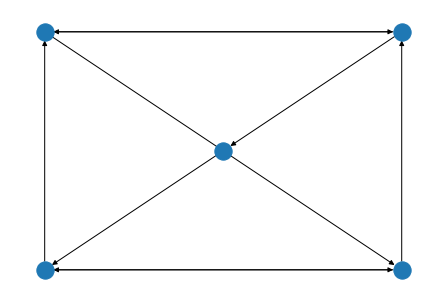

In [109]:
firstFockTest = getGraph(projectedFock.summandList[8])
nx.draw(firstFockTest, nx.multipartite_layout(firstFockTest, "vertex", "horizontal"))

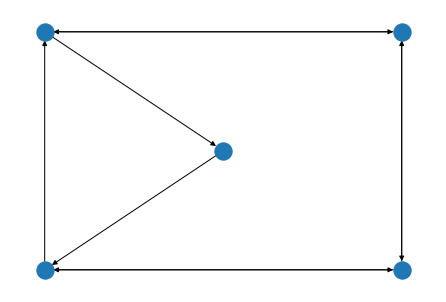

In [110]:
firstFockTest = getGraph(projectedFock.summandList[9])
nx.draw(firstFockTest, nx.multipartite_layout(firstFockTest, "vertex", "horizontal"))

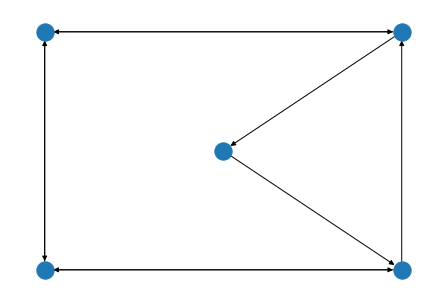

In [111]:
firstFockTest = getGraph(projectedFock.summandList[10])
nx.draw(firstFockTest, nx.multipartite_layout(firstFockTest, "vertex", "horizontal"))

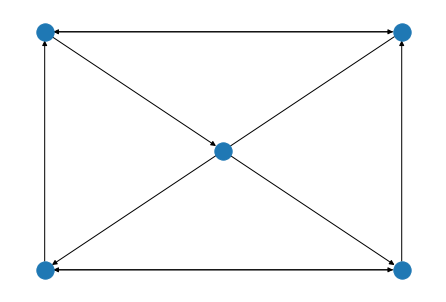

In [112]:
firstFockTest = getGraph(projectedFock.summandList[11])
nx.draw(firstFockTest, nx.multipartite_layout(firstFockTest, "vertex", "horizontal"))

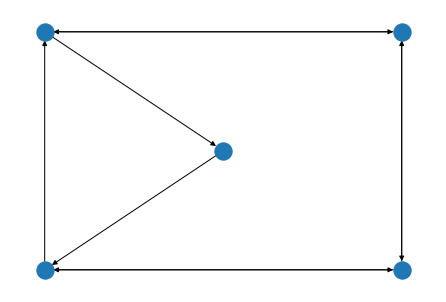

In [113]:
firstFockTest = getGraph(projectedFock.summandList[12])
nx.draw(firstFockTest, nx.multipartite_layout(firstFockTest, "vertex", "horizontal"))

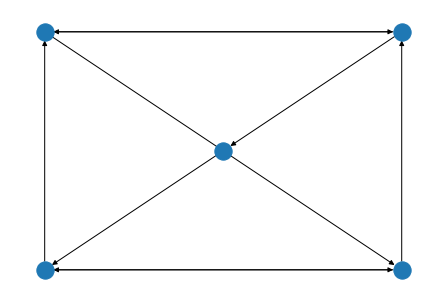

In [114]:
firstFockTest = getGraph(projectedFock.summandList[13])
nx.draw(firstFockTest, nx.multipartite_layout(firstFockTest, "vertex", "horizontal"))

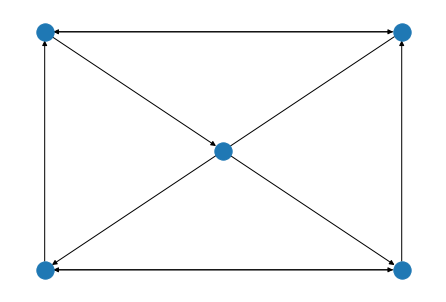

In [115]:
firstFockTest = getGraph(projectedFock.summandList[14])
nx.draw(firstFockTest, nx.multipartite_layout(firstFockTest, "vertex", "horizontal"))

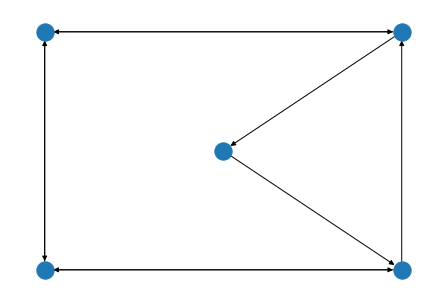

In [116]:
firstFockTest = getGraph(projectedFock.summandList[15])
nx.draw(firstFockTest, nx.multipartite_layout(firstFockTest, "vertex", "horizontal"))

In [117]:
for i in range(8,16):
    print(projectedFock.summandList[i])
    print(isProportional(projectedFock.summandList[i], projectedFock.summandList[11]))
    print((getContractedArray(equation1LinFock.summandList[i])[0] == getContractedArray(equation1LinFock.summandList[11])[0]).all())

-1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{p_{1}}^{p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{1}h_{0}}
True
False
2.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{p_{1}}^{p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{1}h_{0}}
False
False
2.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{p_{0}}^{p_{3}}{t_{2}}_{p_{1}p_{3}}^{h_{1}h_{0}}
False
False
-1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{p_{0}}^{p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{1}h_{0}}
True
True
2.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{p_{1}}^{p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{0}h_{1}}
False
False
-1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{p_{1}}^{p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{0}h_{1}}
True
True
-1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{p_{0}}^{p_{3}}{t_{2}}_{p_{1}p_{3}}^{h_{0}h_{1}}
True
False
2.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{p_{0}}^{p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{0}h_{1}}
False
False


In [118]:
print(getContractedArray(equation1LinFock.summandList[0])[0])
print(getContractedArray(equation1LinFock.summandList[3])[0])
print(getContractedArray(equation1LinFock.summandList[5])[0])
print((getContractedArray(equation1LinFock.summandList[0])[0] == getContractedArray(equation1LinFock.summandList[3])[0]).all())
print((getContractedArray(equation1LinFock.summandList[0])[0] == getContractedArray(equation1LinFock.summandList[5])[0]).all())
print((getContractedArray(equation1LinFock.summandList[3])[0] == getContractedArray(equation1LinFock.summandList[5])[0]).all())

[[[[-0.00034128  0.00576982]
   [ 0.00036934  0.05175528]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.00391859  0.00574334]
   [ 0.00071063  0.0168073 ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]]


 [[[ 0.          0.        ]
   [ 0.          0.        ]]

  [[-0.00034128  0.00576982]
   [ 0.00036934  0.05175528]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.00391859  0.00574334]
   [ 0.00071063  0.0168073 ]]]


 [[[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[-0.00034128  0.00576982]
   [ 0.

In [119]:
print(isProportional(equation1LinFock.summandList[0], equation1LinFock.summandList[3]))
print(isProportional(equation1LinFock.summandList[0], equation1LinFock.summandList[5]))
print(isProportional(equation1LinFock.summandList[3], equation1LinFock.summandList[5]))

True
True
True


In [120]:
print(isProportional(projectedFock.summandList[0], projectedFock.summandList[3]))
print(isProportional(projectedFock.summandList[0], projectedFock.summandList[5]))
print(isProportional(projectedFock.summandList[3], projectedFock.summandList[5]))

True
True
True


In [121]:
print(isProportional1(equation1LinFock.summandList[0], equation1LinFock.summandList[3]))
print(isProportional1(equation1LinFock.summandList[0], equation1LinFock.summandList[5]))
print(isProportional1(equation1LinFock.summandList[3], equation1LinFock.summandList[5]))

True
True
True


In [122]:
print(isProportional1(projectedFock.summandList[0], projectedFock.summandList[3]))
print(isProportional1(projectedFock.summandList[0], projectedFock.summandList[5]))
print(isProportional1(projectedFock.summandList[3], projectedFock.summandList[5]))

True
True
True


In [123]:
print((getContractedArray(equation1LinFock.summandList[8])[0] == getContractedArray(equation1LinFock.summandList[11])[0]).all())

False


In [124]:
def getContractedArray1(tensorProduct_, targetLowerIndexList=None, targetUpperIndexList=None):
    lowerIndexList = list(itertools.chain.from_iterable([vertex.lowerIndices for vertex in tensorProduct_.vertexList]))
    upperIndexList = list(itertools.chain.from_iterable([vertex.upperIndices for vertex in tensorProduct_.vertexList]))
    lowerIndexLetters = string.ascii_lowercase[:len(lowerIndexList)]
    upperIndexLetters = ''
    freeLowerIndexMask = np.ones(len(lowerIndexList))
    freeUpperIndexMask = np.ones(len(upperIndexList))
    nFreeUpperIndices = 0
    for uI, upperIndex in enumerate(upperIndexList):
        free = True
        for lI, lowerIndex in enumerate(lowerIndexList):
            if upperIndex == lowerIndex:
                upperIndexLetters += lowerIndexLetters[lI]
                freeLowerIndexMask[lI] = 0
                freeUpperIndexMask[uI] = 0
                free = False
        if free:
            upperIndexLetters += string.ascii_lowercase[len(lowerIndexList) + nFreeUpperIndices]
            nFreeUpperIndices += 1
    newLowerIndexList = [lowerIndex for lI, lowerIndex in enumerate(lowerIndexList) if freeLowerIndexMask[lI]]
    newUpperIndexList = [upperIndex for uI, upperIndex in enumerate(upperIndexList) if freeUpperIndexMask[uI]]
    print(*newLowerIndexList)
    print(*newUpperIndexList)
    summandZero = False
    if targetLowerIndexList == None and targetUpperIndexList == None:
        targetLowerIndexList = newLowerIndexList
        targetUpperIndexList = newUpperIndexList
        summandZero = True
    freeLowerIndexLetters = "".join([lowerIndexLetters[lowerIndexList.index(lowerIndex)] for lowerIndex in targetLowerIndexList])
    freeUpperIndexLetters = "".join([upperIndexLetters[upperIndexList.index(upperIndex)] for upperIndex in targetUpperIndexList])
    einsumSubstrings = []
    start = 0
    for vertex in tensorProduct_.vertexList:
        end = start + vertex.excitationRank
        einsumSubstring = lowerIndexLetters[start:end] + upperIndexLetters[start:end]
        einsumSubstrings.append(einsumSubstring)
        start = end
    einsumString = ",".join(einsumSubstrings)
    einsumString += '->' + freeLowerIndexLetters + freeUpperIndexLetters
    contribution = tensorProduct_.prefactor * np.einsum(einsumString, *[vertex.tensor.array for vertex in tensorProduct_.vertexList])
    if summandZero:
        return contribution, newLowerIndexList, newUpperIndexList
    return contribution

In [125]:
print(equation1LinFock.summandList[8])
print(equation1LinFock.summandList[11])
print((getContractedArray1(equation1LinFock.summandList[8])[0] == getContractedArray1(equation1LinFock.summandList[11])[0]).all())
print(equation1LinFock.summandList[13])
print((getContractedArray1(equation1LinFock.summandList[8])[0] == getContractedArray1(equation1LinFock.summandList[13])[0]).all())
print(equation1LinFock.summandList[14])
print((getContractedArray1(equation1LinFock.summandList[8])[0] == getContractedArray1(equation1LinFock.summandList[14])[0]).all())

-1.0 * f_{p_{1}}^{p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{1}h_{0}}
-1.0 * f_{p_{0}}^{p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{1}h_{0}}
p_{1} p_{0}
h_{1} h_{0}
p_{0} p_{1}
h_{1} h_{0}
False
-1.0 * f_{p_{1}}^{p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{0}h_{1}}
p_{1} p_{0}
h_{1} h_{0}
p_{1} p_{0}
h_{0} h_{1}
False
-1.0 * f_{p_{0}}^{p_{3}}{t_{2}}_{p_{1}p_{3}}^{h_{0}h_{1}}
p_{1} p_{0}
h_{1} h_{0}
p_{0} p_{1}
h_{0} h_{1}
True


In [126]:
print(projectedDoublesAmplitudeEquation)

2.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{p_{1}p_{0}}^{h_{1}h_{0}}
 + -1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{p_{0}p_{1}}^{h_{1}h_{0}}
 + -1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{p_{1}p_{0}}^{h_{0}h_{1}}
 + 2.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{p_{0}p_{1}}^{h_{0}h_{1}}
 + 1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{1}}
 + -2.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{0}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{1}}
 + -2.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{1}h_{2}}
 + 1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{0}}{t_{2}}_{p_{0}p_{1}}^{h_{1}h_{2}}
 + -2.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{0}}
 + 1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{0}}
 + 1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{0}h_{2}}
 + -2.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{2}}
 + -1.0 *

In [127]:
exchangeProjectedDoublesAmplitudeEquation = copy(projectedDoublesAmplitudeEquation)

In [128]:
for term in exchangeProjectedDoublesAmplitudeEquation.summandList:
    p0 = term.vertexList[0].upperIndices[0]
    p1 = term.vertexList[0].upperIndices[1]
    for vertex in term.vertexList[1:]:
        for lI, lowerIndex in enumerate(vertex.lowerIndices):
            if lowerIndex == p0:
                vertex.lowerIndices[lI] = p1
            elif lowerIndex == p1:
                vertex.lowerIndices[lI] = p0

In [129]:
print(exchangeProjectedDoublesAmplitudeEquation)

2.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{p_{0}p_{1}}^{h_{1}h_{0}}
 + -1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{p_{1}p_{0}}^{h_{1}h_{0}}
 + -1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{p_{0}p_{1}}^{h_{0}h_{1}}
 + 2.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{p_{1}p_{0}}^{h_{0}h_{1}}
 + 1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{0}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{1}}
 + -2.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{1}}
 + -2.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{0}}{t_{2}}_{p_{0}p_{1}}^{h_{1}h_{2}}
 + 1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{1}h_{2}}
 + -2.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{0}}
 + 1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{0}}
 + 1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{2}}
 + -2.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{0}h_{2}}
 + -1.0 *

In [130]:
thirdProjectedDoublesAmplitudeEquation = copy(projectedDoublesAmplitudeEquation)
sixthExchangeProjectedDoublesAmplitudeEquation = copy(exchangeProjectedDoublesAmplitudeEquation)
for term in thirdProjectedDoublesAmplitudeEquation.summandList:
    term.prefactor /= 3.
for term in sixthExchangeProjectedDoublesAmplitudeEquation.summandList:
    term.prefactor /= 6.
biorthogonallyProjectedDoublesAmplitudeEquation = thirdProjectedDoublesAmplitudeEquation + sixthExchangeProjectedDoublesAmplitudeEquation

In [131]:
print(biorthogonallyProjectedDoublesAmplitudeEquation)

0.6666666666666666 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{p_{1}p_{0}}^{h_{1}h_{0}}
 + -0.3333333333333333 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{p_{0}p_{1}}^{h_{1}h_{0}}
 + -0.3333333333333333 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{p_{1}p_{0}}^{h_{0}h_{1}}
 + 0.6666666666666666 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{p_{0}p_{1}}^{h_{0}h_{1}}
 + 0.3333333333333333 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{1}}
 + -0.6666666666666666 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{0}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{1}}
 + -0.6666666666666666 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{1}h_{2}}
 + 0.3333333333333333 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{0}}{t_{2}}_{p_{0}p_{1}}^{h_{1}h_{2}}
 + -0.6666666666666666 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{0}}
 + 0.3333333333333333 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{0}}
 + 0.3333333333333333 * \Phi_{h_{0}h_{1}

In [132]:
def getGraphNew(term, case=0):
    termGraph = nx.DiGraph()
    genNodes(term)
    for v1, vertex1 in enumerate(term.vertexList):
        termGraph.add_nodes_from(vertex1.nodes, vertex=v1, freeOutType="", freeInType="", tensorName=vertex1.tensor.name)
        if case == 0:
            termGraph.add_edges_from(itertools.permutations(vertex1.nodes, 2), connection="interaction")
        elif case == 1:
            termGraph.add_edges_from(itertools.combinations(vertex1.nodes, 2), connection="interaction")
        elif case == 2:
            if vertex1.tensor.name == '\\Phi':
                termGraph.add_edges_from(itertools.combinations(vertex1.nodes, 2), connection="interaction")
            else:
                termGraph.add_edges_from(itertools.permutations(vertex1.nodes, 2), connection="interaction")
        elif case == 3:
            if vertex1.tensor.name == 'v':
                termGraph.add_edges_from(itertools.combinations(vertex1.nodes, 2), connection="interaction")
            else:
                termGraph.add_edges_from(itertools.permutations(vertex1.nodes, 2), connection="interaction")
        elif case == 4:
            if vertex1.tensor.name != '\\Phi' and vertex1.tensor.name != 'v':
                termGraph.add_edges_from(itertools.combinations(vertex1.nodes, 2), connection="interaction")
            else:
                termGraph.add_edges_from(itertools.permutations(vertex1.nodes, 2), connection="interaction")
        elif case == 5:
            if vertex1.tensor.name == '\\Phi' or vertex1.tensor.name == 'v':
#        if vertex1.tensor.name == '\\Phi' or vertex1.tensor.name == 'v':
#        if vertex1.tensor.name == 'v':
#        if v1 == 0:
                termGraph.add_edges_from(itertools.combinations(vertex1.nodes, 2), connection="interaction")
            else:
                termGraph.add_edges_from(itertools.permutations(vertex1.nodes, 2), connection="interaction")
        elif case == 6:
            if vertex1.tensor.name != '\\Phi':
                termGraph.add_edges_from(itertools.combinations(vertex1.nodes, 2), connection="interaction")
            else:
                termGraph.add_edges_from(itertools.permutations(vertex1.nodes, 2), connection="interaction")
        elif case == 7:
            if vertex1.tensor.name != 'v':
                termGraph.add_edges_from(itertools.combinations(vertex1.nodes, 2), connection="interaction")
            else:
                termGraph.add_edges_from(itertools.permutations(vertex1.nodes, 2), connection="interaction")
        for v2, vertex2 in enumerate(term.vertexList):
            for node1 in vertex1.nodes:
                for node2 in vertex2.nodes:
                    if node1.outIndex == node2.inIndex:
                        node1.outContracted = True
                        node2.inContracted = True
                        termGraph.add_edge(node1, node2, connection="propagation")
        for node1 in vertex1.nodes:
            termGraph.nodes[node1]["particle"]=node1.particle
            if not node1.outContracted:
                if node1.outIndex.occupiedInVacuum:
                    termGraph.nodes[node1]["freeOutType"]="h"
                else:
                    termGraph.nodes[node1]["freeOutType"]="p"
            if not node1.inContracted:
                if node1.inIndex.occupiedInVacuum:
                    termGraph.nodes[node1]["freeInType"]="h"
                else:
                    termGraph.nodes[node1]["freeInType"]="p"
    return termGraph

In [133]:
def getGraphOnePerm(term):
    termGraph = nx.DiGraph()
    genNodes(term)
    for v1, vertex1 in enumerate(term.vertexList):
        termGraph.add_nodes_from(vertex1.nodes, vertex=v1, freeOutType="", freeInType="")
        if vertex1.tensor.name == '\\Phi':
#        if vertex1.tensor.name == 'v':
#        if v1 == 0:
            termGraph.add_edges_from(itertools.combinations(vertex1.nodes, 2), connection="interaction")
        else:
            termGraph.add_edges_from(itertools.permutations(vertex1.nodes, 2), connection="interaction")
        #termGraph.add_edges_from(itertools.permutations(vertex1.nodes, 2), connection="interaction")
        for v2, vertex2 in enumerate(term.vertexList):
            for node1 in vertex1.nodes:
                for node2 in vertex2.nodes:
                    if node1.outIndex == node2.inIndex:
                        node1.outContracted = True
                        node2.inContracted = True
                        termGraph.add_edge(node1, node2, connection="propagation")
        for node1 in vertex1.nodes:
            termGraph.nodes[node1]["particle"]=node1.particle
            if not node1.outContracted:
                if node1.outIndex.occupiedInVacuum:
                    termGraph.nodes[node1]["freeOutType"]="h"
                else:
                    termGraph.nodes[node1]["freeOutType"]="p"
            if not node1.inContracted:
                if node1.inIndex.occupiedInVacuum:
                    termGraph.nodes[node1]["freeInType"]="h"
                else:
                    termGraph.nodes[node1]["freeInType"]="p"
    return termGraph

In [134]:
def isProportionalNew(term1, term2, case=0):
    term1Graph = getGraphNew(term1, case)
    term2Graph = getGraphNew(term2, case)
    DiGM = isomorphism.DiGraphMatcher(term1Graph, term2Graph)
    return (term1.tensorList == term2.tensorList) and DiGM.is_isomorphic() and all([DiGM.semantic_feasibility(DiGM.mapping[n], n) for n in DiGM.mapping.keys()])

In [135]:
def isProportionalOnePerm(term1, term2):
    term1Graph = getGraphOnePerm(term1)
    term2Graph = getGraphOnePerm(term2)
    DiGM = isomorphism.DiGraphMatcher(term1Graph, term2Graph)
    return (term1.tensorList == term2.tensorList) and DiGM.is_isomorphic() and all([DiGM.semantic_feasibility(DiGM.mapping[n], n) for n in DiGM.mapping.keys()])

In [136]:
def collectEquationNew(equation, case=0):
    collectedEquation = TensorSum([])
    for summand in equation.summandList:
        included = False
        for uniqueSummand in collectedEquation.summandList:
            if isProportionalNew(summand, uniqueSummand, case):
                included = True
                uniqueSummand.prefactor += summand.prefactor
        if not included:
            collectedEquation.summandList.append(copy(summand))
    return collectedEquation

In [137]:
def collectEquationOnePerm(equation):
    collectedEquation = TensorSum([])
    for summand in equation.summandList:
        included = False
        for uniqueSummand in collectedEquation.summandList:
            if isProportionalOnePerm(summand, uniqueSummand):
                included = True
                uniqueSummand.prefactor += summand.prefactor
        if not included:
            collectedEquation.summandList.append(copy(summand))
    return collectedEquation

In [138]:
collectedBiorthogonalDoublesAmplitudeEquation = collectEquationNew(biorthogonallyProjectedDoublesAmplitudeEquation)

In [139]:
print(collectedBiorthogonalDoublesAmplitudeEquation)

0.9999999999999999 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{p_{1}p_{0}}^{h_{1}h_{0}}
 + 0.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{p_{0}p_{1}}^{h_{1}h_{0}}
 + 1.1102230246251565e-16 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{1}}
 + -2.0000000000000004 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{0}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{1}}
 + -1.1102230246251565e-16 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{p_{1}}^{p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{1}h_{0}}
 + 2.0000000000000004 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{p_{1}}^{p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{1}h_{0}}
 + -5.551115123125783e-17 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{h_{2}h_{3}}^{h_{1}h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{3}h_{2}}
 + 1.0000000000000002 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{h_{2}h_{3}}^{h_{1}h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{3}}
 + -1.0000000000000002 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{h_{2}p_{1}}^{h_{0}p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + 5.551115123125783e-17 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{h_{2}p_{1}}^{h

In [140]:
collectedUnprojectedBiorthogonalDoublesAmplitudeEquation = copy(collectedBiorthogonalDoublesAmplitudeEquation)
for term in collectedUnprojectedBiorthogonalDoublesAmplitudeEquation.summandList:
    term.tensorList.pop(0)
    term.vertexList.pop(0)

In [141]:
def deProjectEquation(equation):
    copiedEquation = copy(equation)
    for term in copiedEquation.summandList:
        term.tensorList.pop(0)
        term.vertexList.pop(0)
    return copiedEquation

In [142]:
print(collectedUnprojectedBiorthogonalDoublesAmplitudeEquation)

0.9999999999999999 * v_{p_{1}p_{0}}^{h_{1}h_{0}}
 + 0.0 * v_{p_{0}p_{1}}^{h_{1}h_{0}}
 + 1.1102230246251565e-16 * f_{h_{2}}^{h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{1}}
 + -2.0000000000000004 * f_{h_{2}}^{h_{0}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{1}}
 + -1.1102230246251565e-16 * f_{p_{1}}^{p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{1}h_{0}}
 + 2.0000000000000004 * f_{p_{1}}^{p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{1}h_{0}}
 + -5.551115123125783e-17 * v_{h_{2}h_{3}}^{h_{1}h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{3}h_{2}}
 + 1.0000000000000002 * v_{h_{2}h_{3}}^{h_{1}h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{3}}
 + -1.0000000000000002 * v_{h_{2}p_{1}}^{h_{0}p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + 5.551115123125783e-17 * v_{h_{2}p_{1}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{2}h_{1}}
 + -1.0000000000000002 * v_{h_{2}p_{0}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + 5.551115123125783e-17 * v_{h_{2}p_{1}}^{p_{3}h_{0}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + -0.9999999999999997 * v_{h_{2}p_{1}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{0}}^{h_{2}h_{

In [143]:
def roundEquation(equation):
    roundedEquation = copy(equation)
    for term in roundedEquation.summandList:
        term.prefactor = round(term.prefactor, 3)
    roundedEquation = TensorSum([term for term in roundedEquation.summandList if term.prefactor != 0])
    return roundedEquation

In [144]:
roundedBiorthogonalDoublesAmplitudeEquation = copy(collectedUnprojectedBiorthogonalDoublesAmplitudeEquation)
for term in roundedBiorthogonalDoublesAmplitudeEquation.summandList:
    term.prefactor = round(term.prefactor, 3)
roundedBiorthogonalDoublesAmplitudeEquation = TensorSum([term for term in roundedBiorthogonalDoublesAmplitudeEquation.summandList if term.prefactor != 0])
print(roundedBiorthogonalDoublesAmplitudeEquation)

1.0 * v_{p_{1}p_{0}}^{h_{1}h_{0}}
 + -2.0 * f_{h_{2}}^{h_{0}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{1}}
 + 2.0 * f_{p_{1}}^{p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{1}h_{0}}
 + 1.0 * v_{h_{2}h_{3}}^{h_{1}h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{3}}
 + -1.0 * v_{h_{2}p_{1}}^{h_{0}p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + -1.0 * v_{h_{2}p_{0}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + -1.0 * v_{h_{2}p_{1}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{0}}^{h_{2}h_{1}}
 + 2.0 * v_{h_{2}p_{0}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + -1.0 * v_{p_{1}h_{2}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{2}h_{1}}
 + 2.0 * v_{p_{0}h_{2}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + -1.0 * v_{p_{1}h_{2}}^{p_{3}h_{0}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + -1.0 * v_{p_{0}h_{2}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + 1.0 * v_{p_{1}p_{0}}^{p_{4}p_{5}}{t_{2}}_{p_{4}p_{5}}^{h_{1}h_{0}}
 + 2.0 * v_{h_{2}h_{3}}^{p_{2}p_{3}}{t_{2}}_{p_{1}p_{0}}^{h_{1}h_{0}}{t_{2}}_{p_{3}p_{2}}^{h_{3}h_{2}}
 + -1.0 * v_{h_{2}h_{3}}^{p_{2}p_{3}

In [145]:
equation6 = roundedBiorthogonalDoublesAmplitudeEquation
equation6Const = TensorSum([summand for summand in equation6.summandList if len(summand.tensorList) == 1])
equation6LinFock = TensorSum([summand for summand in equation6.summandList if len(summand.tensorList) == 2 and summand.tensorList[0].excitationRank == 1])
equation6LinV = TensorSum([summand for summand in equation6.summandList if len(summand.tensorList) == 2 and summand.tensorList[0].excitationRank == 2])
equation6Quad = TensorSum([summand for summand in equation6.summandList if len(summand.tensorList) == 3])

In [146]:
(contractTensorSum(equation1LinFock) == 4 * contractTensorSum(equation6LinFock) - 2 * contractTensorSum(equation6LinFock).swapaxes(0,1)).all()

False

In [147]:
4 * contractTensorSum(equation6LinFock) - 2 * contractTensorSum(equation6LinFock).swapaxes(0,1)

array([[[[ 0.00138902, -0.0234835 ],
         [-0.00188155, -0.26366271]],

        [[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],

        [[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],

        [[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],

        [[-0.01849635, -0.00530111],
         [-0.01258476, -0.25631872]],

        [[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],

        [[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]]],


       [[[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],

        [[ 0.00138902, -0.0234835 ],
         [-0.00188155, -0.26366271]],

        [[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],

        [[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],

        [[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],

        [[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],

        [[

In [148]:
contractTensorSum(equation1LinFock)

array([[[[ 0.00138902, -0.01268252],
         [-0.01268252, -0.26366271]],

        [[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],

        [[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],

        [[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],

        [[-0.01658574, -0.03885519],
         [-0.00090905, -0.12829715]],

        [[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],

        [[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]]],


       [[[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],

        [[ 0.00138902, -0.01268252],
         [-0.01268252, -0.26366271]],

        [[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],

        [[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],

        [[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],

        [[ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],

        [[

In [149]:
print(equation6LinFock)

-2.0 * f_{h_{2}}^{h_{0}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{1}}
 + 2.0 * f_{p_{1}}^{p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{1}h_{0}}


In [150]:
(contractTensorSum(equation6LinFock) == contractTensorSum(equation6LinFock).swapaxes(0,1).swapaxes(2,3)).all()

False

In [151]:
(t2Tensor.array == t2Tensor.array.swapaxes(0,1).swapaxes(2,3)).all()

False

In [152]:
np.amax(abs((t2Tensor.array - t2Tensor.array.swapaxes(0,1).swapaxes(2,3))))

5.551115123125783e-17

In [153]:
print(t2Tensor.array)
print(t2Tensor.array.swapaxes(0,1).swapaxes(2,3))

[[[[ 7.25057988e-05 -1.22582488e-03]
   [-1.22582488e-03 -1.71775864e-01]]

  [[ 0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00]]

  [[ 0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00]]

  [[ 0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00]]

  [[-8.32521512e-04 -1.22019934e-03]
   [-2.35858417e-03 -5.57834516e-02]]

  [[ 0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00]]

  [[ 0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00]]]


 [[[ 0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00]]

  [[ 7.25057988e-05 -1.22582488e-03]
   [-1.22582488e-03 -1.71775864e-01]]

  [[ 0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00]]

  [[ 0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00]]

  [[ 0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00]]

  [[ 0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00]]

  [[-8.325

In [154]:
testEquation = equation6Const + equation6LinFock# + equation6LinV + equation6Quad
#testEquation = equation1Const
t2Tensor.array = np.zeros_like(t2Tensor.array)
residualTensor = Tensor("R", ['p', 'p'], ['h', 'h'])
residualTensor.array = contractTensorSum(testEquation)
#residualTensor.array = (1./3.) * residualTensor.array + (1./6.) * residualTensor.array.swapaxes(0,1)
print(np.amax(abs(residualTensor.array - residualTensor.array.swapaxes(0,1).swapaxes(2,3))))
t2Tensor.array = CC.iterateDoublesAmplitudes(t2Tensor, residualTensor, fockTensor.array)
print(t2Tensor.array)
print(np.amax(abs(t2Tensor.array - t2Tensor.array.swapaxes(0,1).swapaxes(2,3))))
print(contractTensorSum(equationE))

7.546047120499111e-17
[[[[-0.00034461 -0.00127549]
   [-0.00127549 -0.08213441]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[-0.00093956 -0.00121257]
   [-0.00281002 -0.02477347]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]]


 [[[ 0.          0.        ]
   [ 0.          0.        ]]

  [[-0.00034461 -0.00127549]
   [-0.00127549 -0.08213441]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[-0.00093956 -0.00121257]
   [-0.00281002 -0.02477347]]]


 [[[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[-0.0003446

In [155]:
print(equation1Const)
print((1./3.) * contractTensorSum(equation1Const) + (1./6.) * contractTensorSum(equation1Const).swapaxes(0,1))
print(((1./3.) * contractTensorSum(equation1Const) + (1./6.) * contractTensorSum(equation1Const).swapaxes(0,1) == (1./3.) * contractTensorSum(equation1Const).swapaxes(0,1).swapaxes(2,3) + (1./6.) * contractTensorSum(equation1Const).swapaxes(2,3)).all())
print(equation6Const)
print(contractTensorSum(equation6Const))
print((contractTensorSum(equation6Const) == contractTensorSum(equation6Const).swapaxes(0,1).swapaxes(2,3)).all())

2.0 * v_{p_{1}p_{0}}^{h_{1}h_{0}}
 + -1.0 * v_{p_{0}p_{1}}^{h_{1}h_{0}}
 + -1.0 * v_{p_{1}p_{0}}^{h_{0}h_{1}}
 + 2.0 * v_{p_{0}p_{1}}^{h_{0}h_{1}}
[[[[ 0.00330086  0.00659818]
   [ 0.00659818  0.063035  ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.00935906  0.00673648]
   [ 0.01561124  0.02848843]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]]


 [[[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.00330086  0.00659818]
   [ 0.00659818  0.063035  ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.00935906  0.00673648]
   [ 0.01561124  0.02848843]]]


 [[[ 0.  

In [156]:
((1./3.) * contractTensorSum(equation1Const) + (1./6.) * contractTensorSum(equation1Const).swapaxes(0,1)).shape

(7, 7, 2, 2)

In [157]:
(contractTensorSum(equation6Const)).shape

(7, 7, 2, 2)

In [158]:
np.amax(abs((1./3.) * contractTensorSum(equation1LinV) + (1./6.) * contractTensorSum(equation1LinV).swapaxes(0,1) - contractTensorSum(equation6LinV)))

0.0035800469414880996

In [159]:
def contractTensorSum(tensorSum_):
    if len(tensorSum_.summandList) == 0:
        return 0
    contractedArray, lowerIndexList, upperIndexList = getContractedArray(tensorSum_.summandList[0])
#    print(*lowerIndexList)
#    print(*upperIndexList)
    i = 1
    while i < len(tensorSum_.summandList):
        contractedArray += getContractedArray(tensorSum_.summandList[i], lowerIndexList, upperIndexList)
        i += 1
    return contractedArray

In [160]:
print(equation1LinV)
print((1./3.) * contractTensorSum(equation1LinV) + (1./6.) * contractTensorSum(equation1LinV).swapaxes(0,1))
print(equation6LinV)
print(contractTensorSum(equation6LinV))

-0.5 * v_{h_{2}h_{3}}^{h_{1}h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{3}h_{2}}
 + 1.0 * v_{h_{2}h_{3}}^{h_{1}h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{3}}
 + 1.0 * v_{h_{2}h_{3}}^{h_{1}h_{0}}{t_{2}}_{p_{0}p_{1}}^{h_{3}h_{2}}
 + -0.5 * v_{h_{2}h_{3}}^{h_{1}h_{0}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{3}}
 + 1.0 * v_{h_{2}h_{3}}^{h_{0}h_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{3}h_{2}}
 + -0.5 * v_{h_{2}h_{3}}^{h_{0}h_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{3}}
 + -0.5 * v_{h_{2}h_{3}}^{h_{0}h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{3}h_{2}}
 + 1.0 * v_{h_{2}h_{3}}^{h_{0}h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{3}}
 + -1.0 * v_{h_{2}p_{1}}^{h_{0}p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + 0.5 * v_{h_{2}p_{1}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{2}h_{1}}
 + 0.5 * v_{h_{2}p_{0}}^{h_{0}p_{3}}{t_{2}}_{p_{1}p_{3}}^{h_{2}h_{1}}
 + -1.0 * v_{h_{2}p_{0}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + 0.5 * v_{h_{2}p_{1}}^{h_{0}p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{1}h_{2}}
 + -1.0 * v_{h_{2}p_{1}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{1}h_{2}}
 + -1.0 * v_{h_{

In [161]:
len(equation6LinV.summandList)

10

In [162]:
len(equation1LinV.summandList)

80

In [163]:
print(equation6LinV)

1.0 * v_{h_{2}h_{3}}^{h_{1}h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{3}}
 + -1.0 * v_{h_{2}p_{1}}^{h_{0}p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + -1.0 * v_{h_{2}p_{0}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + -1.0 * v_{h_{2}p_{1}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{0}}^{h_{2}h_{1}}
 + 2.0 * v_{h_{2}p_{0}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + -1.0 * v_{p_{1}h_{2}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{2}h_{1}}
 + 2.0 * v_{p_{0}h_{2}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + -1.0 * v_{p_{1}h_{2}}^{p_{3}h_{0}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + -1.0 * v_{p_{0}h_{2}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + 1.0 * v_{p_{1}p_{0}}^{p_{4}p_{5}}{t_{2}}_{p_{4}p_{5}}^{h_{1}h_{0}}


In [164]:
testArray, targetLower, targetUpper = getContractedArray(equation1LinV.summandList[0])
for s, summand in enumerate(equation1LinV.summandList):
    if np.amax(abs(getContractedArray(summand, targetLower, targetUpper) - testArray)) < 0.0000000001:
        print(s, summand)

0 -0.5 * v_{h_{2}h_{3}}^{h_{1}h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{3}h_{2}}
3 -0.5 * v_{h_{2}h_{3}}^{h_{1}h_{0}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{3}}
5 -0.5 * v_{h_{2}h_{3}}^{h_{0}h_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{3}}
6 -0.5 * v_{h_{2}h_{3}}^{h_{0}h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{3}h_{2}}


In [165]:
print(equation6LinV.summandList[0])
print(getContractedArray(equation6LinV.summandList[0], targetLower, targetUpper))
print(equation6LinV.summandList[9])
print(getContractedArray(equation6LinV.summandList[9], targetLower, targetUpper))

1.0 * v_{h_{2}h_{3}}^{h_{1}h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{3}}
[[[[-2.60423732e-03 -5.14179898e-05]
   [-5.14179898e-05 -2.91070560e-02]]

  [[ 0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00]]

  [[ 0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00]]

  [[ 0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00]]

  [[-2.03289979e-03 -3.27336071e-04]
   [-1.07328444e-03 -8.78132993e-03]]

  [[ 0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00]]

  [[ 0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00]]]


 [[[ 0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00]]

  [[-2.60423732e-03 -5.14179898e-05]
   [-5.14179898e-05 -2.91070560e-02]]

  [[ 0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00]]

  [[ 0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00]]

  [[ 0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00]]

  [[ 0.00000000e+00

In [166]:
projectedDoublesAmplitudeEquation.summandList[0].vertexList[0].tensor.name

'\\Phi'

In [167]:
convergeDoublesAmplitudesNonBiorth(t2Tensor, equationECollected, equation6, fockTensor)

[[[[ 0.00330086  0.00659818]
   [ 0.00659818  0.063035  ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.00935906  0.00673648]
   [ 0.01561124  0.02848843]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]]


 [[[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.00330086  0.00659818]
   [ 0.00659818  0.063035  ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.00935906  0.00673648]
   [ 0.01561124  0.02848843]]]


 [[[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]]

  [[ 0.00330086  0.00659818]
   [ 0.

KeyboardInterrupt: 

In [168]:
print(trueCCD.kernel())

(-0.046469771227442426, (array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]]), array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])), (array([[[[ 0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ]],

        [[ 0.        ,  0.        ,

In [169]:
contractTensorSum(energyEquation)

nan

In [170]:
bohr = 0.529177249

H2sep = 1.605 * bohr
N2sep = 1.605 * bohr

mol = gto.Mole()
mol.verbose = 1
#mol.atom = 'Ne 0 0 0'
#mol.atom = 'H 0 0 0; H 0 0 ' + str(H2sep)
mol.atom = 'N 0 0 0; N 0 0 1.09'
mol.basis = 'sto-3g'
#mol.basis = '6-31g'
mol.spin = 0
mol.build()

Enuc = mol.energy_nuc()

mf = scf.ROHF(mol)
mf.kernel()

cisolver = fci.FCI(mol, mf.mo_coeff)

Norbs = mol.nao
Nocc = mf.nelectron_alpha
vacuum = [1] * Nocc + [0] * (Norbs - Nocc)

h1 = mf.mo_coeff.T.dot(mf.get_hcore()).dot(mf.mo_coeff)
eri = ao2mo.kernel(mol, mf.mo_coeff, compact=False)

h2Tensor.array = eri.reshape((Norbs, Norbs, Norbs, Norbs)).swapaxes(2,3).swapaxes(1,2)

fock = h1
for p in range(Norbs):
    for q in range(Norbs):
        fock[p,q] += sum([2 * h2Tensor.array[p,i,q,i] - h2Tensor.array[p,i,i,q] for i in range(Nocc)])
fockTensor.array = fock

fockTensor.assignDiagramArrays(vacuum)
h2Tensor.assignDiagramArrays(vacuum)
t2Tensor.getShape(vacuum)

In [171]:
Norbs

10

In [172]:
trueCCD = cc.CCSD(mf)
old_update_amps = trueCCD.update_amps
def update_amps(t1, t2, eris):
    t1, t2 = old_update_amps(t1, t2, eris)
#    print(t1)
    return (np.zeros_like(t1[0]), np.zeros_like(t1[1])), t2
trueCCD.update_amps = update_amps
trueCCD.diis = False
print(trueCCD.kernel())

(-0.1506586505143484, (array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])), (array([[[[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
         [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
         [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00]],

        [[-0.00000000e+00, -8.48968033e-22,  2.72322835e-19],
         [ 8.48968033e-22, -0.00000000e+00,  1.81731777e-21],
         [-2.72322835e-19, -1.81731777e-21, -0.00000000e+00]],

        [[-0.00000000e+00, -4.96256032e-21, -2.86538880e-18],
         [ 4.96256032e-21, -0.00000000e+00, -2.14274212e-20],
         [ 2.86538880e-18,  2.14274212e-20, -0.00000000e+00]],

        [[-0.00000000e+00, -1.98827862e-20,  1.64834977e-18],
         [ 1.98827862e-20, -0.00000000e+00, -1.5399

In [173]:
convergeDoublesAmplitudesNonBiorth(t2Tensor, equationECollected, equation6, fockTensor)

[[[[ 1.38740161e-02 -1.67835211e-15  1.34275572e-02 -4.46949762e-14
    -2.31789477e-16  2.40928556e-17  8.67137213e-03]
   [-1.68105806e-15  1.45678456e-02  3.23009410e-14  1.85669277e-02
     5.00077092e-17 -3.74951693e-19  2.09176252e-14]
   [ 1.34275572e-02  3.22994490e-14  4.39484677e-02 -7.20885832e-17
    -4.41240576e-16  4.88939811e-17  2.50454494e-02]
   [-4.46957080e-14  1.85669277e-02 -7.59624378e-17  8.23756760e-02
     2.35933252e-16 -8.59434696e-18  1.41470309e-16]
   [-2.31789477e-16  5.00077092e-17 -4.41240576e-16  2.35933252e-16
     1.85570099e-01 -1.40020829e-02  2.47869012e-15]
   [ 2.40928556e-17 -3.74951693e-19  4.88939811e-17 -8.59434696e-18
    -1.40020829e-02  2.01300214e-02 -1.96188280e-16]
   [ 8.67137213e-03  2.09143849e-14  2.50454494e-02  1.31667573e-16
     2.47869012e-15 -1.96188280e-16  3.84527057e-02]]

  [[ 1.38558811e-18  7.20941063e-19  4.19771588e-19 -2.33866156e-20
    -5.33374659e-18 -6.93352067e-17  2.46930417e-19]
   [ 7.67042754e-19  8.7155495

KeyboardInterrupt: 

In [174]:
CC.convergeDoublesAmplitudes(t2Tensor, energyEquation, equation1, fockTensor)

[[[[ 1.38740161e-02 -1.67970508e-15  1.34275572e-02 -4.46953421e-14
    -2.31789477e-16  2.40928556e-17  8.67137213e-03]
   [-1.67970508e-15  1.45678456e-02  3.23001950e-14  1.85669277e-02
     5.00077092e-17 -3.74951693e-19  2.09160050e-14]
   [ 1.34275572e-02  3.23001950e-14  4.39484677e-02 -7.40255105e-17
    -4.41240576e-16  4.88939811e-17  2.50454494e-02]
   [-4.46953421e-14  1.85669277e-02 -7.40255105e-17  8.23756760e-02
     2.35933252e-16 -8.59434696e-18  1.36568941e-16]
   [-2.31789477e-16  5.00077092e-17 -4.41240576e-16  2.35933252e-16
     1.85570099e-01 -1.40020829e-02  2.47869012e-15]
   [ 2.40928556e-17 -3.74951693e-19  4.88939811e-17 -8.59434696e-18
    -1.40020829e-02  2.01300214e-02 -1.96188280e-16]
   [ 8.67137213e-03  2.09160050e-14  2.50454494e-02  1.36568941e-16
     2.47869012e-15 -1.96188280e-16  3.84527057e-02]]

  [[ 1.33013914e-18  9.06972037e-19  6.51195738e-19  5.55315526e-19
    -5.33374659e-18 -6.93352067e-17  5.49990133e-19]
   [ 7.27965862e-19  9.2793591

In [175]:
print(equation1LinV)

-0.5 * v_{h_{2}h_{3}}^{h_{1}h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{3}h_{2}}
 + 1.0 * v_{h_{2}h_{3}}^{h_{1}h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{3}}
 + 1.0 * v_{h_{2}h_{3}}^{h_{1}h_{0}}{t_{2}}_{p_{0}p_{1}}^{h_{3}h_{2}}
 + -0.5 * v_{h_{2}h_{3}}^{h_{1}h_{0}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{3}}
 + 1.0 * v_{h_{2}h_{3}}^{h_{0}h_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{3}h_{2}}
 + -0.5 * v_{h_{2}h_{3}}^{h_{0}h_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{3}}
 + -0.5 * v_{h_{2}h_{3}}^{h_{0}h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{3}h_{2}}
 + 1.0 * v_{h_{2}h_{3}}^{h_{0}h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{3}}
 + -1.0 * v_{h_{2}p_{1}}^{h_{0}p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + 0.5 * v_{h_{2}p_{1}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{2}h_{1}}
 + 0.5 * v_{h_{2}p_{0}}^{h_{0}p_{3}}{t_{2}}_{p_{1}p_{3}}^{h_{2}h_{1}}
 + -1.0 * v_{h_{2}p_{0}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + 0.5 * v_{h_{2}p_{1}}^{h_{0}p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{1}h_{2}}
 + -1.0 * v_{h_{2}p_{1}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{1}h_{2}}
 + -1.0 * v_{h_{

In [176]:
print(equation6LinV)

1.0 * v_{h_{2}h_{3}}^{h_{1}h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{3}}
 + -1.0 * v_{h_{2}p_{1}}^{h_{0}p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + -1.0 * v_{h_{2}p_{0}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + -1.0 * v_{h_{2}p_{1}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{0}}^{h_{2}h_{1}}
 + 2.0 * v_{h_{2}p_{0}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + -1.0 * v_{p_{1}h_{2}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{2}h_{1}}
 + 2.0 * v_{p_{0}h_{2}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + -1.0 * v_{p_{1}h_{2}}^{p_{3}h_{0}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + -1.0 * v_{p_{0}h_{2}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + 1.0 * v_{p_{1}p_{0}}^{p_{4}p_{5}}{t_{2}}_{p_{4}p_{5}}^{h_{1}h_{0}}


In [177]:
print(equation6LinV.summandList[2])
print(equation6LinV.summandList[7])

-1.0 * v_{h_{2}p_{0}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
-1.0 * v_{p_{1}h_{2}}^{p_{3}h_{0}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}


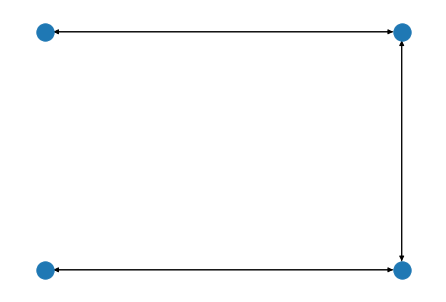

In [178]:
g1 = equation6LinV.summandList[4].getGraph()
g2 = equation6LinV.summandList[6].getGraph()
nx.draw(g1, nx.multipartite_layout(g1, "vertex", "horizontal"))

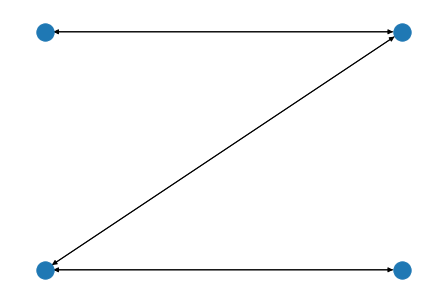

In [179]:
nx.draw(g2, nx.multipartite_layout(g2, "vertex", "horizontal"))

In [180]:
print(roundEquation(collectEquationNew(TensorSum([summand for summand in biorthogonallyProjectedDoublesAmplitudeEquation.summandList if len(summand.tensorList) == 3 and summand.tensorList[1].excitationRank == 2]))))

1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{h_{2}h_{3}}^{h_{1}h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{3}}
 + -1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{h_{2}p_{1}}^{h_{0}p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + -1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{h_{2}p_{0}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + -1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{h_{2}p_{1}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{0}}^{h_{2}h_{1}}
 + 2.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{h_{2}p_{0}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + -1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{p_{1}h_{2}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{2}h_{1}}
 + 2.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{p_{0}h_{2}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + -1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{p_{1}h_{2}}^{p_{3}h_{0}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + -1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{p_{0}h_{2}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + 1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{p_{1}p_{0}}^{p_{4}p_{5}}{t_{2}}_{p_{4}p_{5}}^{h_{1}h_{0

In [181]:
print(roundEquation(collectEquation(TensorSum([summand for summand in biorthogonallyProjectedDoublesAmplitudeEquation.summandList if len(summand.tensorList) == 3 and summand.tensorList[1].excitationRank == 2]))))

1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{h_{2}h_{3}}^{h_{1}h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{3}}
 + -1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{h_{2}p_{1}}^{h_{0}p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + -1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{h_{2}p_{0}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + -1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{h_{2}p_{1}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{0}}^{h_{2}h_{1}}
 + 2.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{h_{2}p_{0}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + -1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{p_{1}h_{2}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{2}h_{1}}
 + 2.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{p_{0}h_{2}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + -1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{p_{1}h_{2}}^{p_{3}h_{0}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + -1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{p_{0}h_{2}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + 1.0 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{p_{1}p_{0}}^{p_{4}p_{5}}{t_{2}}_{p_{4}p_{5}}^{h_{1}h_{0

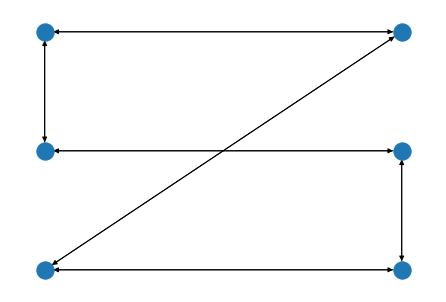

In [182]:
eq = roundEquation(collectEquationNew(TensorSum([summand for summand in biorthogonallyProjectedDoublesAmplitudeEquation.summandList if len(summand.tensorList) == 3 and summand.tensorList[1].excitationRank == 2])))
g = getGraphNew(eq.summandList[4])
nx.draw(g, nx.multipartite_layout(g, "vertex", "horizontal"))

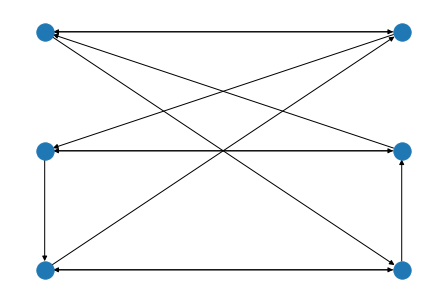

In [183]:
eq = roundEquation(collectEquation(TensorSum([summand for summand in biorthogonallyProjectedDoublesAmplitudeEquation.summandList if len(summand.tensorList) == 3 and summand.tensorList[1].excitationRank == 2])))
g = getGraph(eq.summandList[1])
nx.draw(g, nx.multipartite_layout(g, "vertex", "horizontal"))

In [184]:
equation7 = roundEquation(deProjectEquation(collectEquation(biorthogonallyProjectedDoublesAmplitudeEquation)))
equation7Const = TensorSum([summand for summand in equation7.summandList if len(summand.tensorList) == 1])
equation7LinFock = TensorSum([summand for summand in equation7.summandList if len(summand.tensorList) == 2 and summand.tensorList[0].excitationRank == 1])
equation7LinV = TensorSum([summand for summand in equation7.summandList if len(summand.tensorList) == 2 and summand.tensorList[0].excitationRank == 2])
equation7Quad = TensorSum([summand for summand in equation7.summandList if len(summand.tensorList) == 3])

In [185]:
print(equation7LinV)

1.0 * v_{h_{2}h_{3}}^{h_{1}h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{3}}
 + -1.0 * v_{h_{2}p_{1}}^{h_{0}p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + -1.0 * v_{h_{2}p_{0}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + -1.0 * v_{h_{2}p_{1}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{0}}^{h_{2}h_{1}}
 + 2.0 * v_{h_{2}p_{0}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + -1.0 * v_{p_{1}h_{2}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{2}h_{1}}
 + 2.0 * v_{p_{0}h_{2}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + -1.0 * v_{p_{1}h_{2}}^{p_{3}h_{0}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + -1.0 * v_{p_{0}h_{2}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + 1.0 * v_{p_{1}p_{0}}^{p_{4}p_{5}}{t_{2}}_{p_{4}p_{5}}^{h_{1}h_{0}}


In [186]:
test = TensorSum(equation7LinV.summandList[1:-1])

In [187]:
print(test)

-1.0 * v_{h_{2}p_{1}}^{h_{0}p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + -1.0 * v_{h_{2}p_{0}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + -1.0 * v_{h_{2}p_{1}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{0}}^{h_{2}h_{1}}
 + 2.0 * v_{h_{2}p_{0}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + -1.0 * v_{p_{1}h_{2}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{2}h_{1}}
 + 2.0 * v_{p_{0}h_{2}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + -1.0 * v_{p_{1}h_{2}}^{p_{3}h_{0}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + -1.0 * v_{p_{0}h_{2}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}


In [188]:
np.amax(abs(contractTensorSum(test) - contractTensorSum(test).swapaxes(0,1).swapaxes(2,3)))

0.04671129049240148

In [189]:
np.amax(abs(contractTensorSum(equation7LinV) - contractTensorSum(equation7LinV).swapaxes(0,1).swapaxes(2,3)))

0.0467112904924015

In [190]:
np.amax(abs(h2Tensor.array - h2Tensor.array.swapaxes(0,1).swapaxes(2,3)))

1.0967113655642178e-15

In [191]:
print(equation6LinV)

1.0 * v_{h_{2}h_{3}}^{h_{1}h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{3}}
 + -1.0 * v_{h_{2}p_{1}}^{h_{0}p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + -1.0 * v_{h_{2}p_{0}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + -1.0 * v_{h_{2}p_{1}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{0}}^{h_{2}h_{1}}
 + 2.0 * v_{h_{2}p_{0}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + -1.0 * v_{p_{1}h_{2}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{2}h_{1}}
 + 2.0 * v_{p_{0}h_{2}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + -1.0 * v_{p_{1}h_{2}}^{p_{3}h_{0}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + -1.0 * v_{p_{0}h_{2}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + 1.0 * v_{p_{1}p_{0}}^{p_{4}p_{5}}{t_{2}}_{p_{4}p_{5}}^{h_{1}h_{0}}


In [192]:
np.amax(abs(contractTensorSum(equation6LinV) - contractTensorSum(equation6LinV).swapaxes(0,1).swapaxes(2,3)))

0.0467112904924015

In [193]:
np.amax(abs(contractTensorSum(TensorSum(equation6LinV.summandList[2:-2])) - contractTensorSum(TensorSum(equation6LinV.summandList[2:-2])).swapaxes(0,1).swapaxes(2,3)))

0.041474934344045235

In [194]:
np.amax(abs(contractTensorSum(TensorSum(equation6LinV.summandList[:1])) - contractTensorSum(TensorSum(equation6LinV.summandList[:1])).swapaxes(0,1).swapaxes(2,3)))

1.457167719820518e-16

In [195]:
np.amax(abs(contractTensorSum(TensorSum(equation6LinV.summandList[-1:])) - contractTensorSum(TensorSum(equation6LinV.summandList[-1:])).swapaxes(0,1).swapaxes(2,3)))

1.734723475976807e-16

In [196]:
equation8 = roundEquation(deProjectEquation(collectEquationOnePerm(biorthogonallyProjectedDoublesAmplitudeEquation)))
equation8Const = TensorSum([summand for summand in equation8.summandList if len(summand.tensorList) == 1])
equation8LinFock = TensorSum([summand for summand in equation8.summandList if len(summand.tensorList) == 2 and summand.tensorList[0].excitationRank == 1])
equation8LinV = TensorSum([summand for summand in equation8.summandList if len(summand.tensorList) == 2 and summand.tensorList[0].excitationRank == 2])
equation8Quad = TensorSum([summand for summand in equation8.summandList if len(summand.tensorList) == 3])

In [197]:
print(equation8LinV)

1.0 * v_{h_{2}h_{3}}^{h_{1}h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{3}}
 + -1.0 * v_{h_{2}p_{1}}^{h_{0}p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + -0.5 * v_{h_{2}p_{0}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + -0.5 * v_{h_{2}p_{1}}^{h_{1}p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{2}h_{0}}
 + -0.5 * v_{h_{2}p_{0}}^{p_{3}h_{0}}{t_{2}}_{p_{1}p_{3}}^{h_{2}h_{1}}
 + 2.0 * v_{h_{2}p_{0}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + -0.5 * v_{h_{2}p_{1}}^{p_{3}h_{1}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{0}}
 + -0.5 * v_{p_{0}h_{2}}^{h_{0}p_{3}}{t_{2}}_{p_{1}p_{3}}^{h_{2}h_{1}}
 + 2.0 * v_{p_{0}h_{2}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + -0.5 * v_{p_{1}h_{2}}^{h_{1}p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{0}}
 + -1.0 * v_{p_{1}h_{2}}^{p_{3}h_{0}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + -0.5 * v_{p_{0}h_{2}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + -0.5 * v_{p_{1}h_{2}}^{p_{3}h_{1}}{t_{2}}_{p_{3}p_{0}}^{h_{2}h_{0}}
 + 1.0 * v_{p_{1}p_{0}}^{p_{4}p_{5}}{t_{2}}_{p_{4}p_{5}}^{h_{1}h_{0}}


In [198]:
for case in range(8):
    equation = roundEquation(deProjectEquation(collectEquationNew(biorthogonallyProjectedDoublesAmplitudeEquation, case)))
    equationConst = TensorSum([summand for summand in equation.summandList if len(summand.tensorList) == 1])
    equationLinFock = TensorSum([summand for summand in equation.summandList if len(summand.tensorList) == 2 and summand.tensorList[0].excitationRank == 1])
    equationLinV = TensorSum([summand for summand in equation.summandList if len(summand.tensorList) == 2 and summand.tensorList[0].excitationRank == 2])
    equationQuad = TensorSum([summand for summand in equation.summandList if len(summand.tensorList) == 3])
    print("Case", case)
    print(np.amax(abs(contractTensorSum(equation) - contractTensorSum(equation).swapaxes(0,1).swapaxes(2,3))) < 0.000000001)
    print(equationConst)
    print(equationLinFock)
    print(equationLinV)

Case 0
False
1.0 * v_{p_{1}p_{0}}^{h_{1}h_{0}}
-2.0 * f_{h_{2}}^{h_{0}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{1}}
 + 2.0 * f_{p_{1}}^{p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{1}h_{0}}
1.0 * v_{h_{2}h_{3}}^{h_{1}h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{3}}
 + -1.0 * v_{h_{2}p_{1}}^{h_{0}p_{3}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + -1.0 * v_{h_{2}p_{0}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + -1.0 * v_{h_{2}p_{1}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{0}}^{h_{2}h_{1}}
 + 2.0 * v_{h_{2}p_{0}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + -1.0 * v_{p_{1}h_{2}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{0}}^{h_{2}h_{1}}
 + 2.0 * v_{p_{0}h_{2}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + -1.0 * v_{p_{1}h_{2}}^{p_{3}h_{0}}{t_{2}}_{p_{0}p_{3}}^{h_{2}h_{1}}
 + -1.0 * v_{p_{0}h_{2}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
 + 1.0 * v_{p_{1}p_{0}}^{p_{4}p_{5}}{t_{2}}_{p_{4}p_{5}}^{h_{1}h_{0}}
Case 1
False
0.5 * v_{p_{1}p_{0}}^{h_{1}h_{0}}
 + 0.5 * v_{p_{0}p_{1}}^{h_{0}h_{1}}
-0.5 * f_{h_{2}}^{h_{0}}{t_{2}}_{p_{0}p_{1}}^{h_

In [199]:
print(biorthogonallyProjectedDoublesAmplitudeEquation)

0.6666666666666666 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{p_{1}p_{0}}^{h_{1}h_{0}}
 + -0.3333333333333333 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{p_{0}p_{1}}^{h_{1}h_{0}}
 + -0.3333333333333333 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{p_{1}p_{0}}^{h_{0}h_{1}}
 + 0.6666666666666666 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{p_{0}p_{1}}^{h_{0}h_{1}}
 + 0.3333333333333333 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{1}}
 + -0.6666666666666666 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{0}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{1}}
 + -0.6666666666666666 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{0}}{t_{2}}_{p_{1}p_{0}}^{h_{1}h_{2}}
 + 0.3333333333333333 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{0}}{t_{2}}_{p_{0}p_{1}}^{h_{1}h_{2}}
 + -0.6666666666666666 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{2}h_{0}}
 + 0.3333333333333333 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}f_{h_{2}}^{h_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{2}h_{0}}
 + 0.3333333333333333 * \Phi_{h_{0}h_{1}

In [200]:
a = biorthogonallyProjectedDoublesAmplitudeEquation.summandList[47]
b = biorthogonallyProjectedDoublesAmplitudeEquation.summandList[53]
c = biorthogonallyProjectedDoublesAmplitudeEquation.summandList[63]

In [201]:
print(a)
print(b)
print(c)

0.6666666666666666 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{h_{2}p_{0}}^{p_{3}h_{0}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}
0.6666666666666666 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{h_{2}p_{1}}^{p_{3}h_{1}}{t_{2}}_{p_{3}p_{0}}^{h_{2}h_{0}}
0.6666666666666666 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{p_{0}h_{2}}^{h_{0}p_{3}}{t_{2}}_{p_{3}p_{1}}^{h_{2}h_{1}}


In [202]:
def drawGraph(graph):
    nx.draw(graph, nx.multipartite_layout(graph, "vertex", "horizontal"))

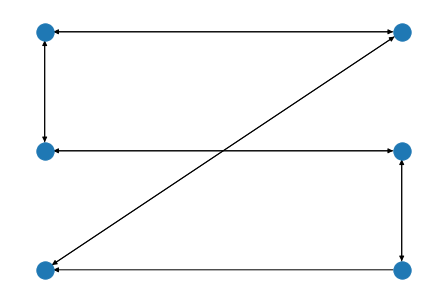

In [203]:
drawGraph(getGraphNew(a, case=2))

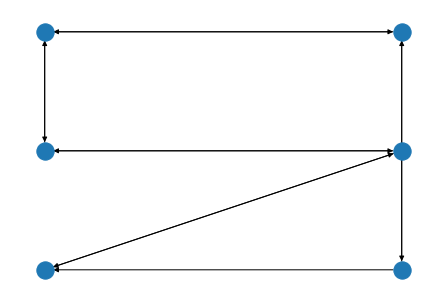

In [204]:
drawGraph(getGraphNew(b, case=2))

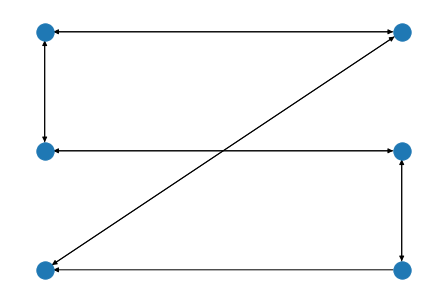

In [205]:
drawGraph(getGraphNew(c, case=2))

In [206]:
class TensorProductGraphMatcher(isomorphism.DiGraphMatcher):
    def __init__(self, tPGraph1, tPGraph2):
        isomorphism.DiGraphMatcher.__init__(self, tPGraph1, tPGraph2)
    
    def semantic_feasibility(self, G1_node, G2_node):
        return

In [207]:
def nodeMatch(node1, node2):
    return node1["tensorName"] == node2["tensorName"] and node1["freeInType"] == node2["freeInType"] and node1["freeOutType"] == node2["freeOutType"]

In [208]:
def edgeMatch(edge1, edge2):
    return edge1["connection"] == edge2["connection"]

In [233]:
def isProportionalNew(term1, term2, case=0):
    term1Graph = getGraphNew(term1, case)
    term2Graph = getGraphNew(term2, case)
    DiGM = isomorphism.DiGraphMatcher(term1Graph, term2Graph, nodeMatch, edgeMatch)
    print(term1.tensorList == term2.tensorList)
    print([t.name for t in term1.tensorList], [t.name for t in term2.tensorList])
    print([t.name for t in term1.tensorList] == [t.name for t in term2.tensorList])
    print(sorted([t.name for t in term1.tensorList]) == sorted([t.name for t in term2.tensorList]))
    print(DiGM.is_isomorphic())
#    print(all([DiGM.semantic_feasibility(DiGM.mapping[n], n) for n in DiGM.mapping.keys()]))
#    for n in DiGM.mapping.keys():
#        print(n, DiGM.mapping[n], DiGM.semantic_feasibility(DiGM.mapping[n], n))
    return (sorted([t.name for t in term1.tensorList]) == sorted([t.name for t in term2.tensorList])) and DiGM.is_isomorphic()

In [210]:
isProportionalNew(a, c, case=2)

False
True
True


True

In [211]:
isProportionalNew(a, b, case=2)

True
True
False


False

In [212]:
a.isProportional(b)

False

In [213]:
a.isProportional(c)

True

In [214]:
b.isProportional(c)

False

In [215]:
print(biorthogonallyProjectedDoublesAmplitudeEquation.summandList[675])

0.3333333333333333 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{h_{2}h_{3}}^{p_{2}p_{3}}{t_{2}}_{p_{2}p_{3}}^{h_{2}h_{3}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{1}}


In [235]:
for t, term in enumerate(biorthogonallyProjectedDoublesAmplitudeEquation.summandList):
    if isProportionalNew(biorthogonallyProjectedDoublesAmplitudeEquation.summandList[259],term):
        print(t, term)

False
['\\Phi', 'v', '{t_{2}}', '{t_{2}}'] ['\\Phi', 'v']
False
False
False
False
['\\Phi', 'v', '{t_{2}}', '{t_{2}}'] ['\\Phi', 'v']
False
False
False
False
['\\Phi', 'v', '{t_{2}}', '{t_{2}}'] ['\\Phi', 'v']
False
False
False
False
['\\Phi', 'v', '{t_{2}}', '{t_{2}}'] ['\\Phi', 'v']
False
False
False
False
['\\Phi', 'v', '{t_{2}}', '{t_{2}}'] ['\\Phi', 'f', '{t_{2}}']
False
False
False
False
['\\Phi', 'v', '{t_{2}}', '{t_{2}}'] ['\\Phi', 'f', '{t_{2}}']
False
False
False
False
['\\Phi', 'v', '{t_{2}}', '{t_{2}}'] ['\\Phi', 'f', '{t_{2}}']
False
False
False
False
['\\Phi', 'v', '{t_{2}}', '{t_{2}}'] ['\\Phi', 'f', '{t_{2}}']
False
False
False
False
['\\Phi', 'v', '{t_{2}}', '{t_{2}}'] ['\\Phi', 'f', '{t_{2}}']
False
False
False
False
['\\Phi', 'v', '{t_{2}}', '{t_{2}}'] ['\\Phi', 'f', '{t_{2}}']
False
False
False
False
['\\Phi', 'v', '{t_{2}}', '{t_{2}}'] ['\\Phi', 'f', '{t_{2}}']
False
False
False
False
['\\Phi', 'v', '{t_{2}}', '{t_{2}}'] ['\\Phi', 'f', '{t_{2}}']
False
False
False


In [221]:
for t, term in enumerate(biorthogonallyProjectedDoublesAmplitudeEquation.summandList):
    if biorthogonallyProjectedDoublesAmplitudeEquation.summandList[258].isProportional(term):
        print(t, term)

101 -0.16666666666666666 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{h_{2}h_{3}}^{p_{2}p_{3}}{t_{2}}_{p_{1}p_{0}}^{h_{1}h_{0}}{t_{2}}_{p_{2}p_{3}}^{h_{3}h_{2}}
102 -0.16666666666666666 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{h_{2}h_{3}}^{p_{2}p_{3}}{t_{2}}_{p_{1}p_{0}}^{h_{1}h_{0}}{t_{2}}_{p_{3}p_{2}}^{h_{2}h_{3}}
257 -0.16666666666666666 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{h_{2}h_{3}}^{p_{2}p_{3}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{1}}{t_{2}}_{p_{2}p_{3}}^{h_{3}h_{2}}
258 -0.16666666666666666 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{h_{2}h_{3}}^{p_{2}p_{3}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{1}}{t_{2}}_{p_{3}p_{2}}^{h_{2}h_{3}}
517 -0.16666666666666666 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{h_{2}h_{3}}^{p_{2}p_{3}}{t_{2}}_{p_{2}p_{3}}^{h_{3}h_{2}}{t_{2}}_{p_{1}p_{0}}^{h_{1}h_{0}}
518 -0.16666666666666666 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{h_{2}h_{3}}^{p_{2}p_{3}}{t_{2}}_{p_{3}p_{2}}^{h_{2}h_{3}}{t_{2}}_{p_{1}p_{0}}^{h_{1}h_{0}}
673 -0.16666666666666666 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}v_{h_{2}h_{3}}^{p_{2}p_{3}}{t_{2}}_{p

In [222]:
for t, term in enumerate(biorthogonallyProjectedDoublesAmplitudeEquation.summandList):
    if biorthogonallyProjectedDoublesAmplitudeEquation.summandList[691].isProportional(term):
        print(t, term)

676 -0.3333333333333333 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{1}h_{0}}v_{h_{4}h_{5}}^{p_{4}p_{5}}{t_{2}}_{p_{5}p_{4}}^{h_{5}h_{4}}
679 -0.3333333333333333 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{1}h_{0}}v_{h_{4}h_{5}}^{p_{4}p_{5}}{t_{2}}_{p_{4}p_{5}}^{h_{4}h_{5}}
688 -0.3333333333333333 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{1}}v_{h_{4}h_{5}}^{p_{4}p_{5}}{t_{2}}_{p_{5}p_{4}}^{h_{5}h_{4}}
691 -0.3333333333333333 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{1}}v_{h_{4}h_{5}}^{p_{4}p_{5}}{t_{2}}_{p_{4}p_{5}}^{h_{4}h_{5}}
692 -0.3333333333333333 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{1}h_{0}}v_{h_{4}h_{5}}^{p_{4}p_{5}}{t_{2}}_{p_{5}p_{4}}^{h_{5}h_{4}}
695 -0.3333333333333333 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{1}h_{0}}v_{h_{4}h_{5}}^{p_{4}p_{5}}{t_{2}}_{p_{4}p_{5}}^{h_{4}h_{5}}
704 -0.3333333333333333 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{1}}v_{h_{4}h_{

In [223]:
for t, term in enumerate(biorthogonallyProjectedDoublesAmplitudeEquation.summandList):
    if biorthogonallyProjectedDoublesAmplitudeEquation.summandList[690].isProportional(term):
        print(t, term)

677 0.16666666666666666 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{1}h_{0}}v_{h_{4}h_{5}}^{p_{4}p_{5}}{t_{2}}_{p_{4}p_{5}}^{h_{5}h_{4}}
678 0.16666666666666666 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{1}h_{0}}v_{h_{4}h_{5}}^{p_{4}p_{5}}{t_{2}}_{p_{5}p_{4}}^{h_{4}h_{5}}
689 0.16666666666666666 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{1}}v_{h_{4}h_{5}}^{p_{4}p_{5}}{t_{2}}_{p_{4}p_{5}}^{h_{5}h_{4}}
690 0.16666666666666666 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{1}}v_{h_{4}h_{5}}^{p_{4}p_{5}}{t_{2}}_{p_{5}p_{4}}^{h_{4}h_{5}}
693 0.16666666666666666 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{1}h_{0}}v_{h_{4}h_{5}}^{p_{4}p_{5}}{t_{2}}_{p_{4}p_{5}}^{h_{5}h_{4}}
694 0.16666666666666666 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}{t_{2}}_{p_{1}p_{0}}^{h_{1}h_{0}}v_{h_{4}h_{5}}^{p_{4}p_{5}}{t_{2}}_{p_{5}p_{4}}^{h_{4}h_{5}}
705 0.16666666666666666 * \Phi_{h_{0}h_{1}}^{p_{0}p_{1}}{t_{2}}_{p_{0}p_{1}}^{h_{0}h_{1}}v_{h_{4}h_{

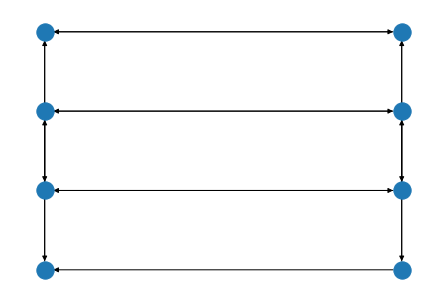

In [224]:
drawGraph(biorthogonallyProjectedDoublesAmplitudeEquation.summandList[259].getGraph())

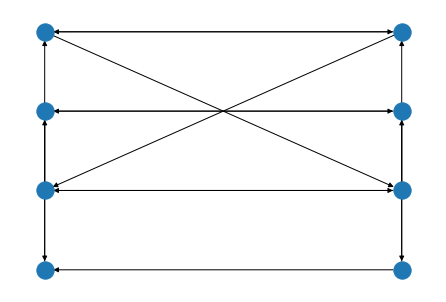

In [225]:
drawGraph(biorthogonallyProjectedDoublesAmplitudeEquation.summandList[258].getGraph())

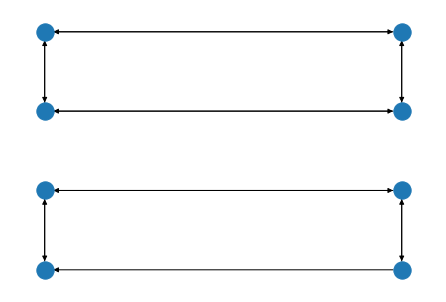

In [226]:
drawGraph(biorthogonallyProjectedDoublesAmplitudeEquation.summandList[691].getGraph())

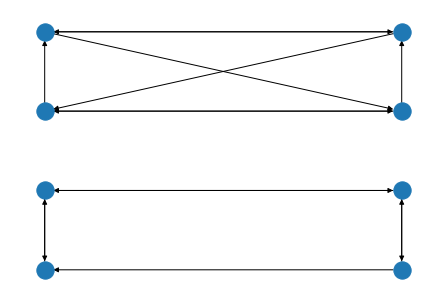

In [228]:
drawGraph(biorthogonallyProjectedDoublesAmplitudeEquation.summandList[690].getGraph())

In [234]:
isProportionalNew(biorthogonallyProjectedDoublesAmplitudeEquation.summandList[259], biorthogonallyProjectedDoublesAmplitudeEquation.summandList[691], case=2)

False
['\\Phi', 'v', '{t_{2}}', '{t_{2}}'] ['\\Phi', '{t_{2}}', 'v', '{t_{2}}']
False
True
True


True